In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 100, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

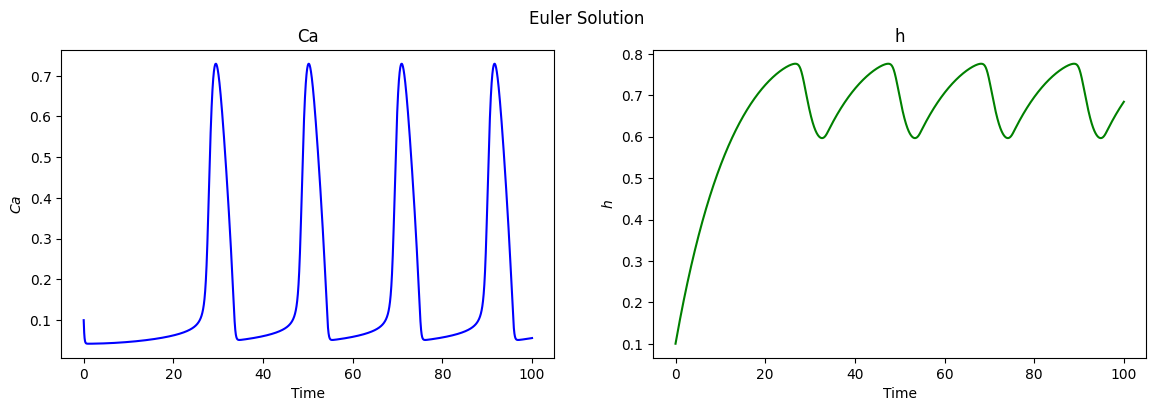

In [3]:
v2 = 0.1
a2 = 0.15
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
class PinnModel(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(in_features=1, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(x)))))))
        return out

In [6]:
Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32, device=device)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32, device=device)[::100]

Training step: 0
Loss = 0.07526350766420364 | Physics_loss = 0.9024626016616821| Initial_loss = 0.05993877351284027 | Data_loss = 0.6300103664398193


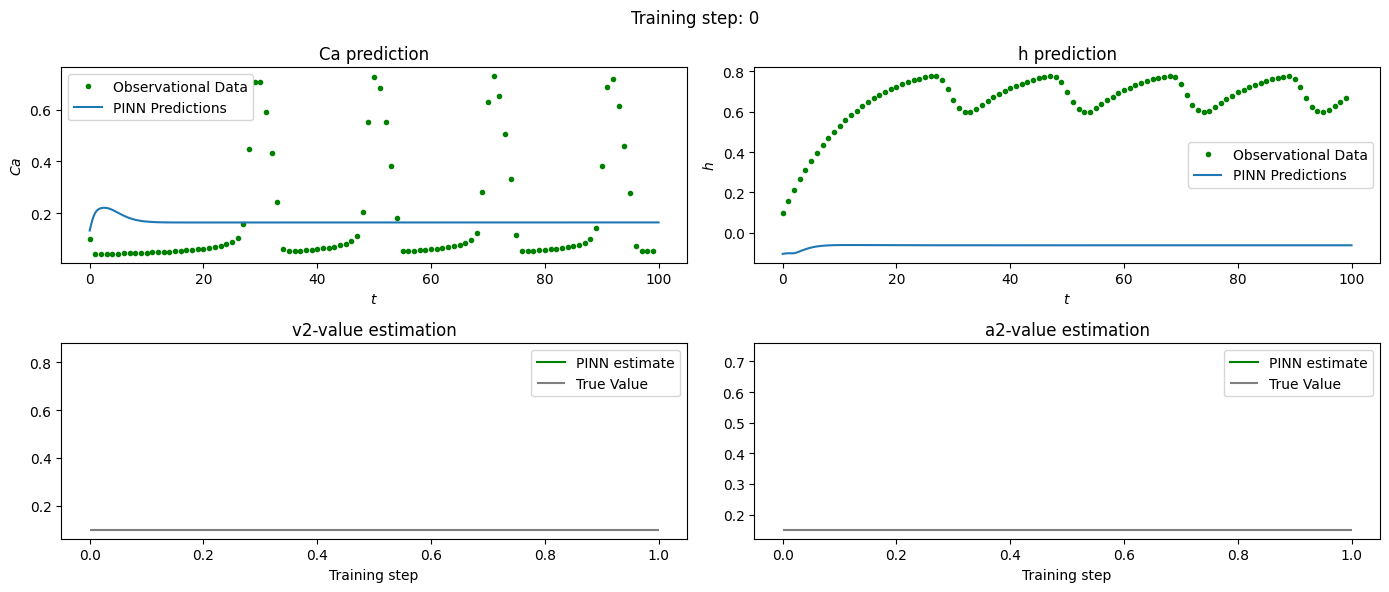

Training step: 1000
Loss = 0.0005343552329577506 | Physics_loss = 0.0028077205643057823| Initial_loss = 7.725489692411713e-10 | Data_loss = 0.050627727061510086


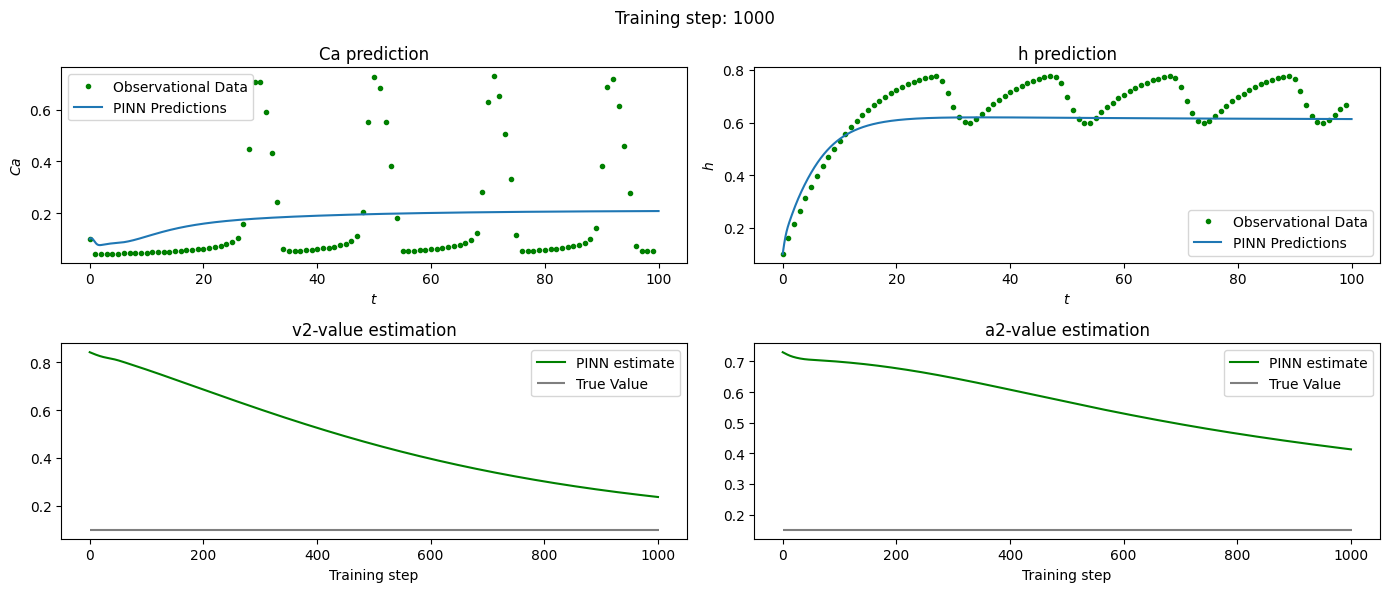

Training step: 2000
Loss = 0.0004491749859880656 | Physics_loss = 0.0005868651205673814| Initial_loss = 3.670817538825588e-10 | Data_loss = 0.044330596923828125


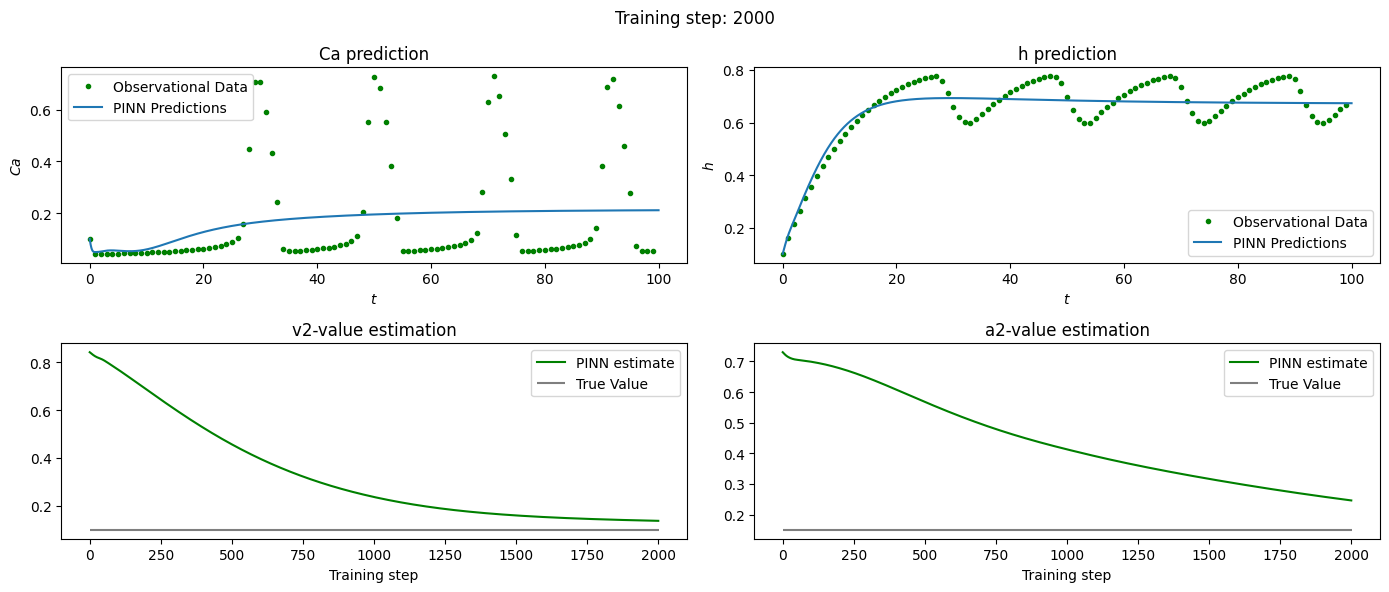

Training step: 3000
Loss = 0.0004433155118022114 | Physics_loss = 0.00035385595401749015| Initial_loss = 4.220235716445586e-09 | Data_loss = 0.0439772754907608


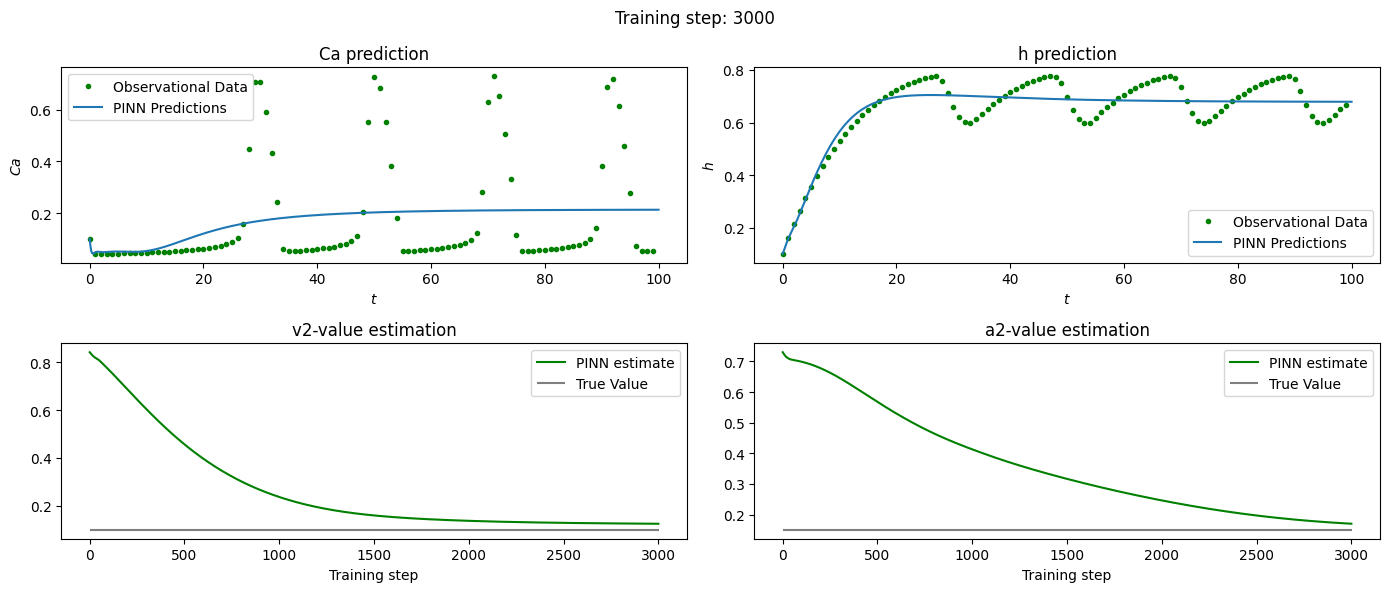

Training step: 4000
Loss = 0.0004413897404447198 | Physics_loss = 0.00027842115378007293| Initial_loss = 3.1235569686316467e-11 | Data_loss = 0.043860550969839096


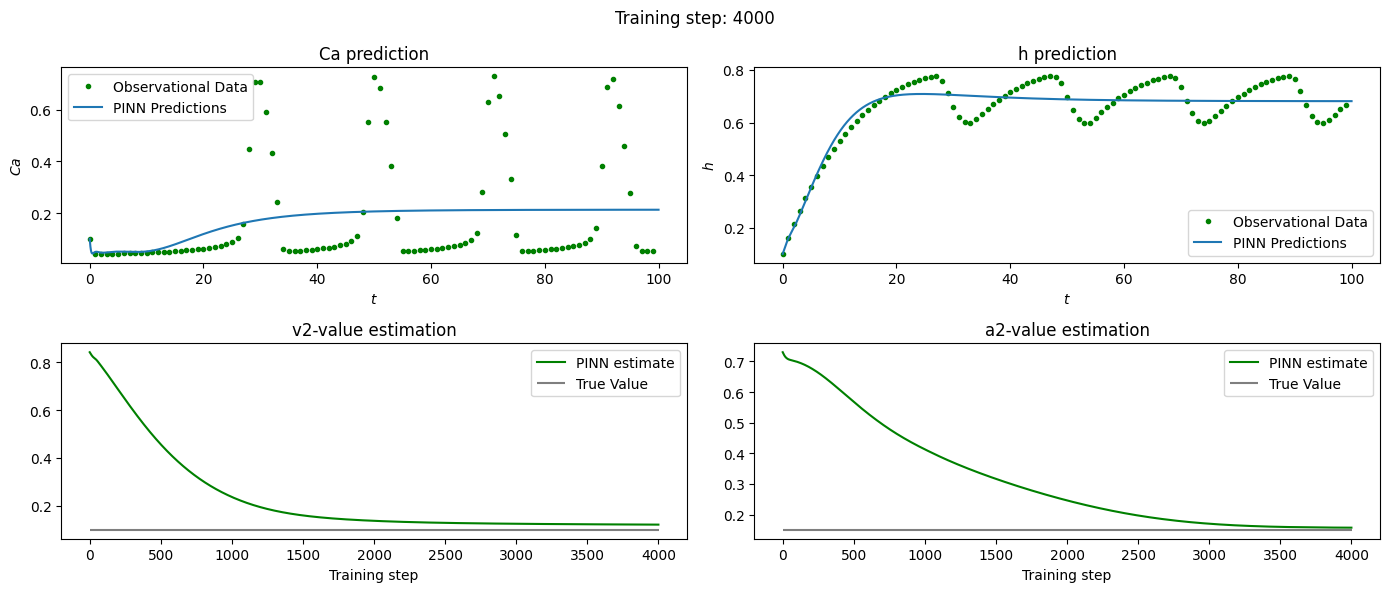

Training step: 5000
Loss = 0.00044034369057044387 | Physics_loss = 0.0002342356601729989| Initial_loss = 4.037704615100779e-10 | Data_loss = 0.04380009323358536


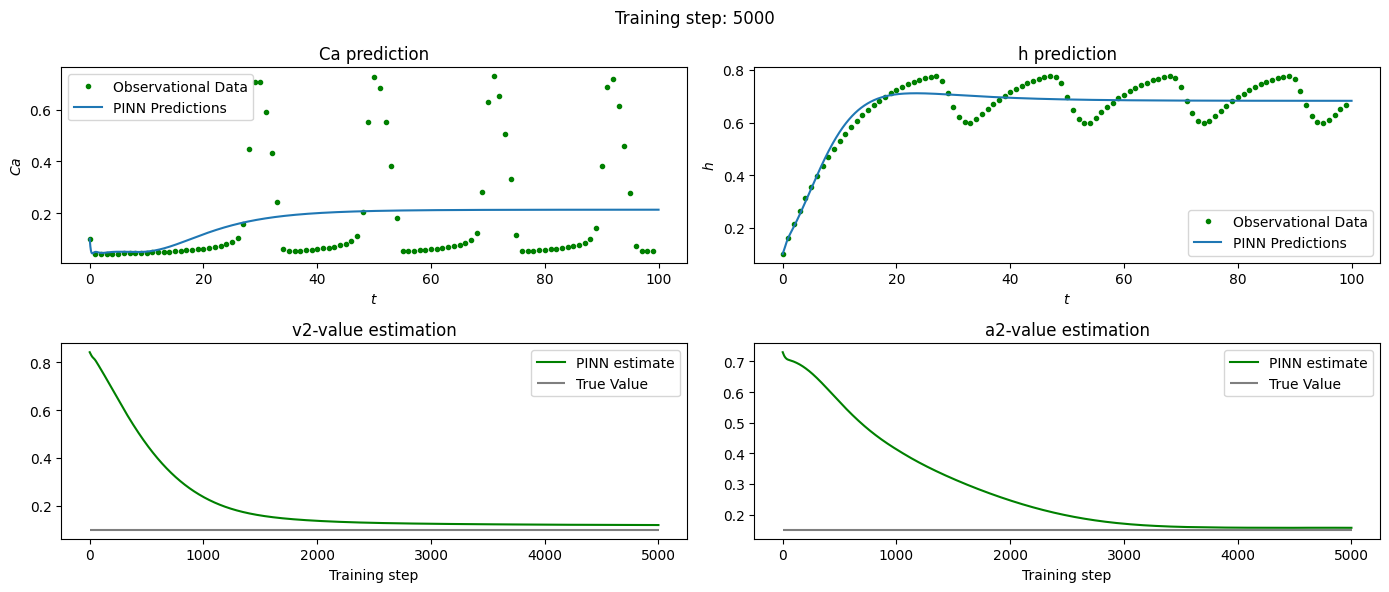

Training step: 6000
Loss = 0.00043974045547656715 | Physics_loss = 0.00020860473159700632| Initial_loss = 2.567945855957987e-13 | Data_loss = 0.043765440583229065


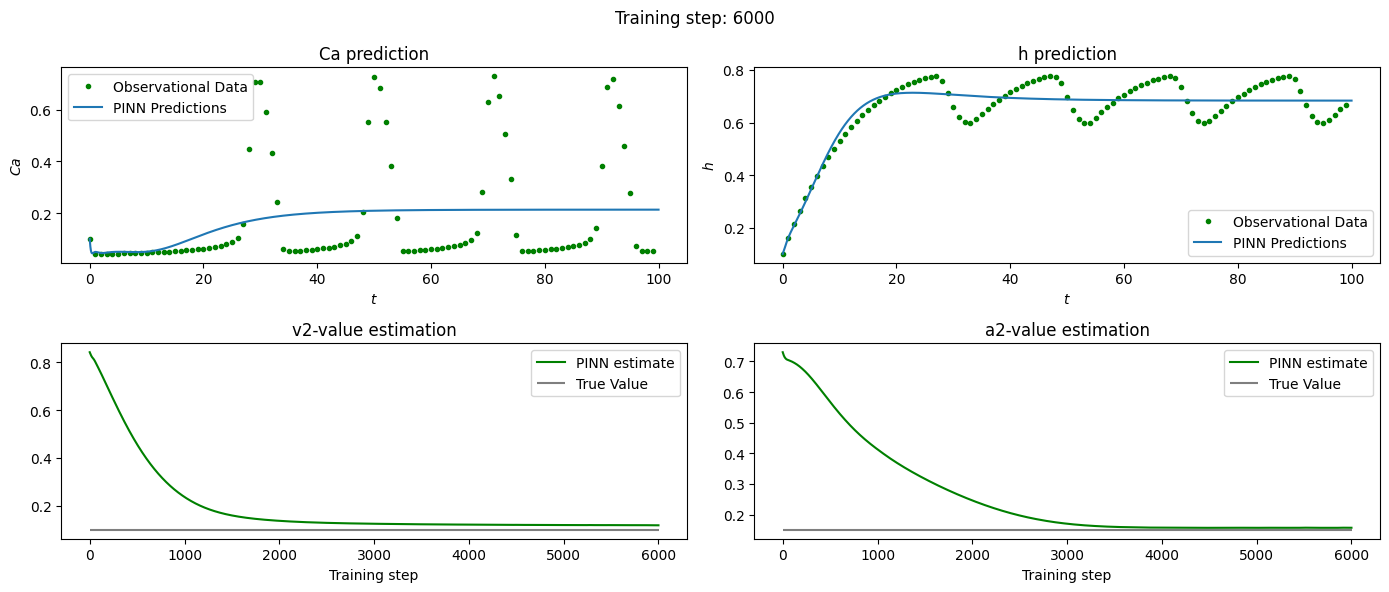

Training step: 7000
Loss = 0.00043941420153714716 | Physics_loss = 0.0001944715913850814| Initial_loss = 1.1529721621883482e-11 | Data_loss = 0.0437469482421875


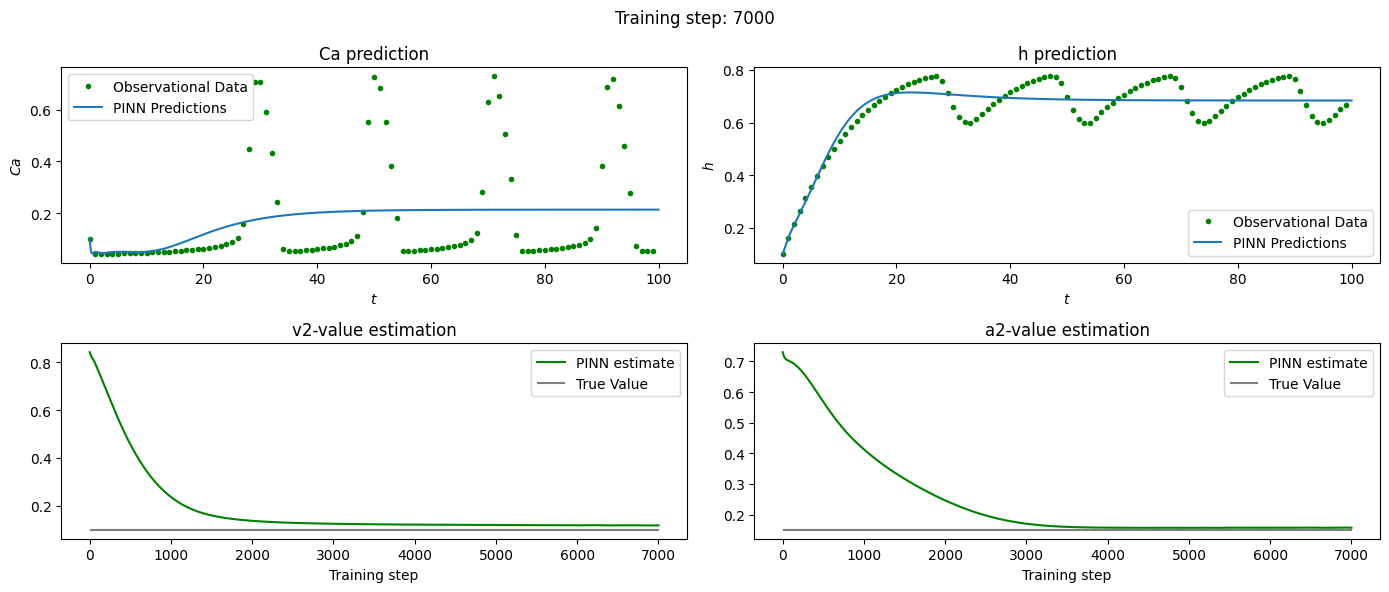

Training step: 8000
Loss = 0.00043915852438658476 | Physics_loss = 0.00018379787798039615| Initial_loss = 1.1748909622966153e-09 | Data_loss = 0.043731939047575


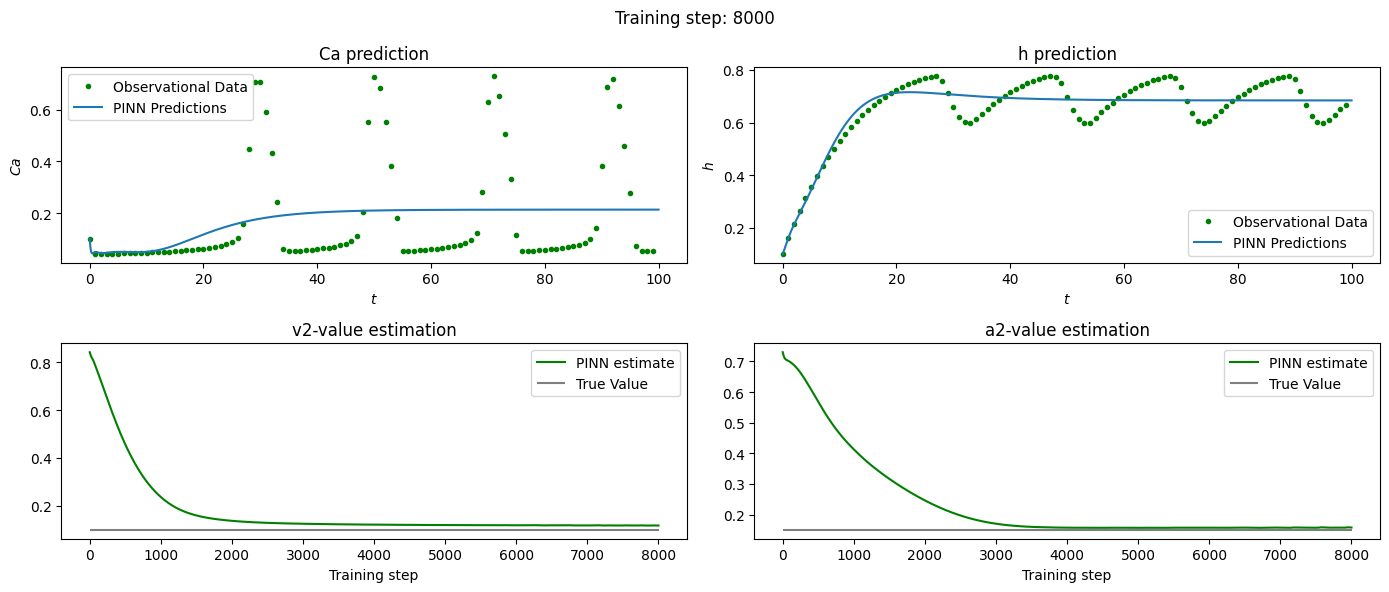

Training step: 9000
Loss = 0.0004391114634927362 | Physics_loss = 0.00017477467190474272| Initial_loss = 1.0229967983832466e-07 | Data_loss = 0.04372614249587059


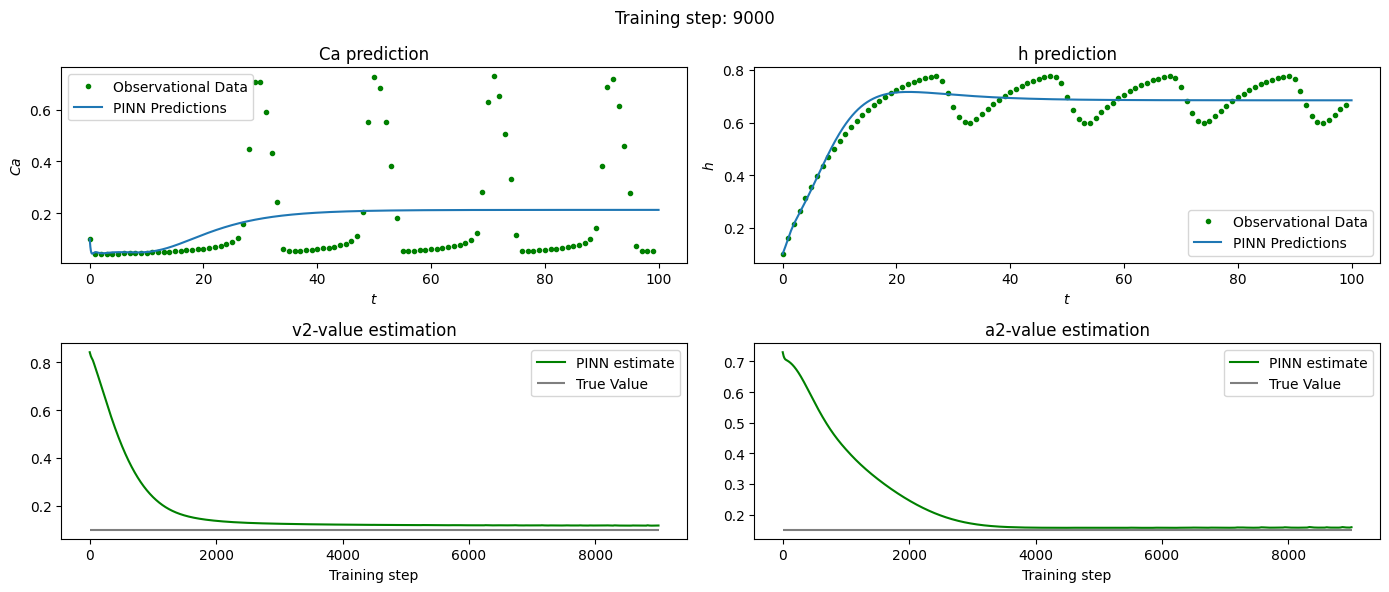

Training step: 10000
Loss = 0.00043886087951250374 | Physics_loss = 0.00017259223386645317| Initial_loss = 1.530892603796019e-07 | Data_loss = 0.04369818791747093


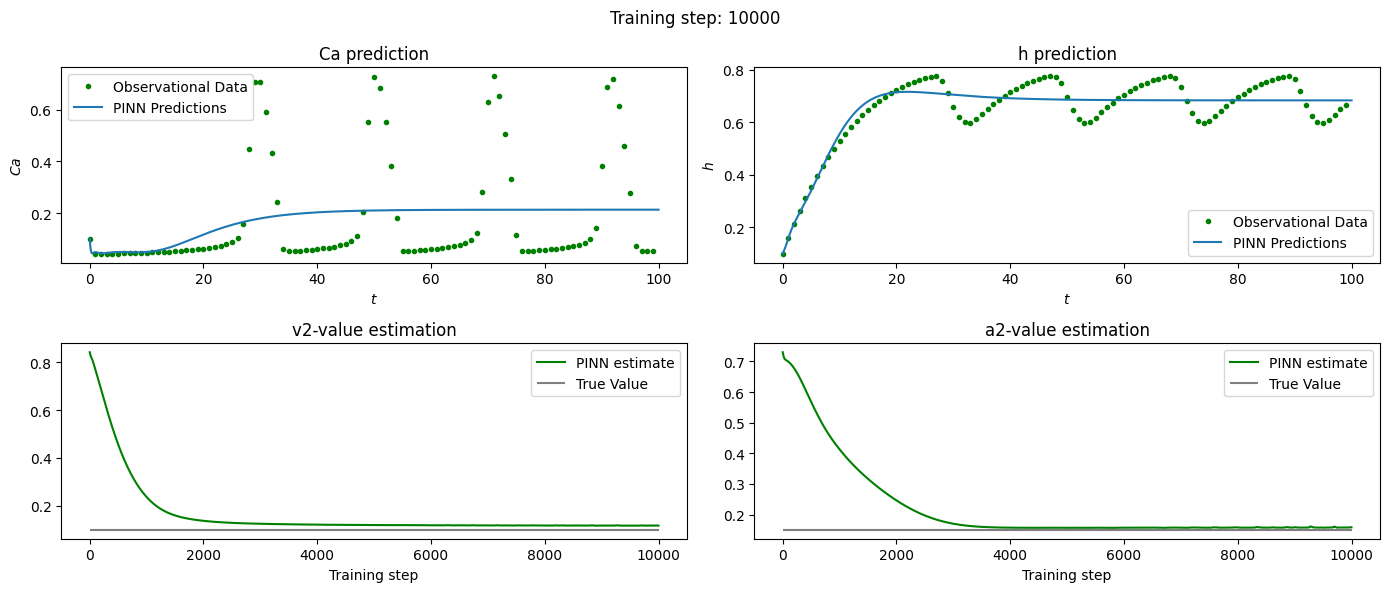

In [7]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30)

t_test = torch.arange(0, 100, 0.01).view(-1, 1).to(device)
time = torch.arange(0, 100, 1.0).view(-1, 1).to(device)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1).to(device)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.1, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [11]:
class PinnModel(nn.Module):
    def __init__(self, hidden_units, y0):
        super().__init__()
        self.y0 = y0
        self.layer1 = nn.Linear(in_features=1, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(x)))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

Training step: 0
Loss = 0.010127129033207893 | Physics_loss = 0.5216382145881653| Initial_loss = 0.0 | Data_loss = 0.4910747706890106


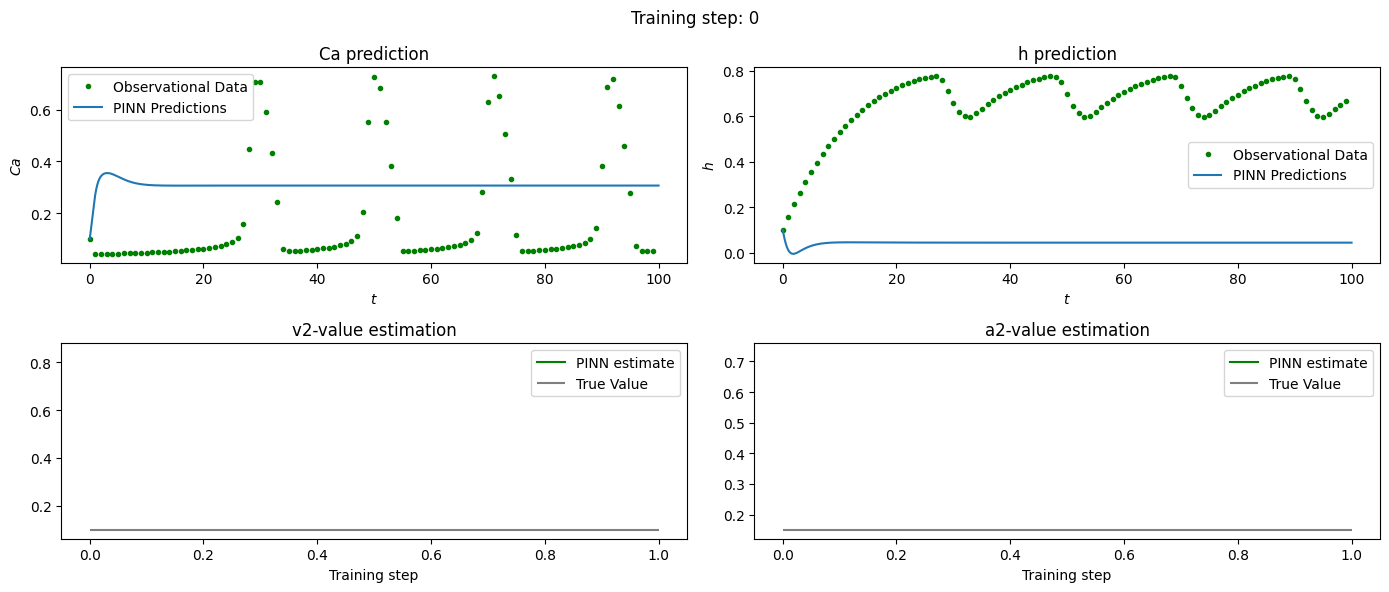

Training step: 1000
Loss = 0.0004993013571947813 | Physics_loss = 0.0016709360061213374| Initial_loss = 0.0 | Data_loss = 0.048259198665618896


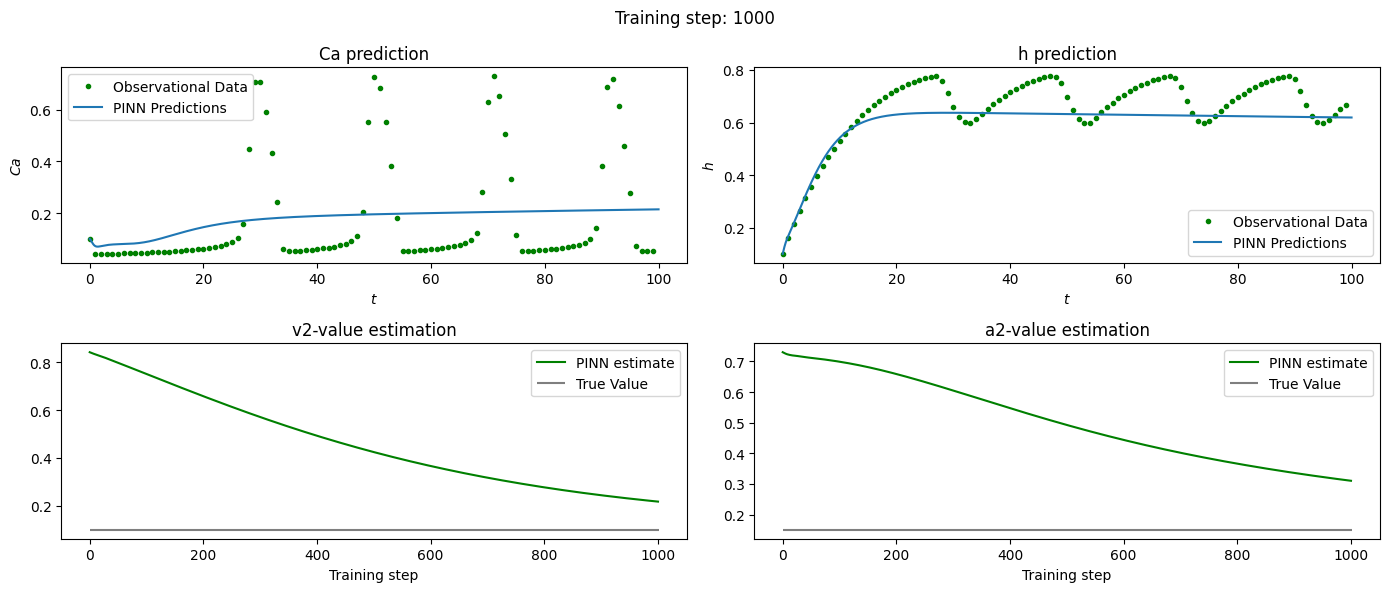

Training step: 2000
Loss = 0.0004373069677967578 | Physics_loss = 0.00013144133845344186| Initial_loss = 0.0 | Data_loss = 0.04359925538301468


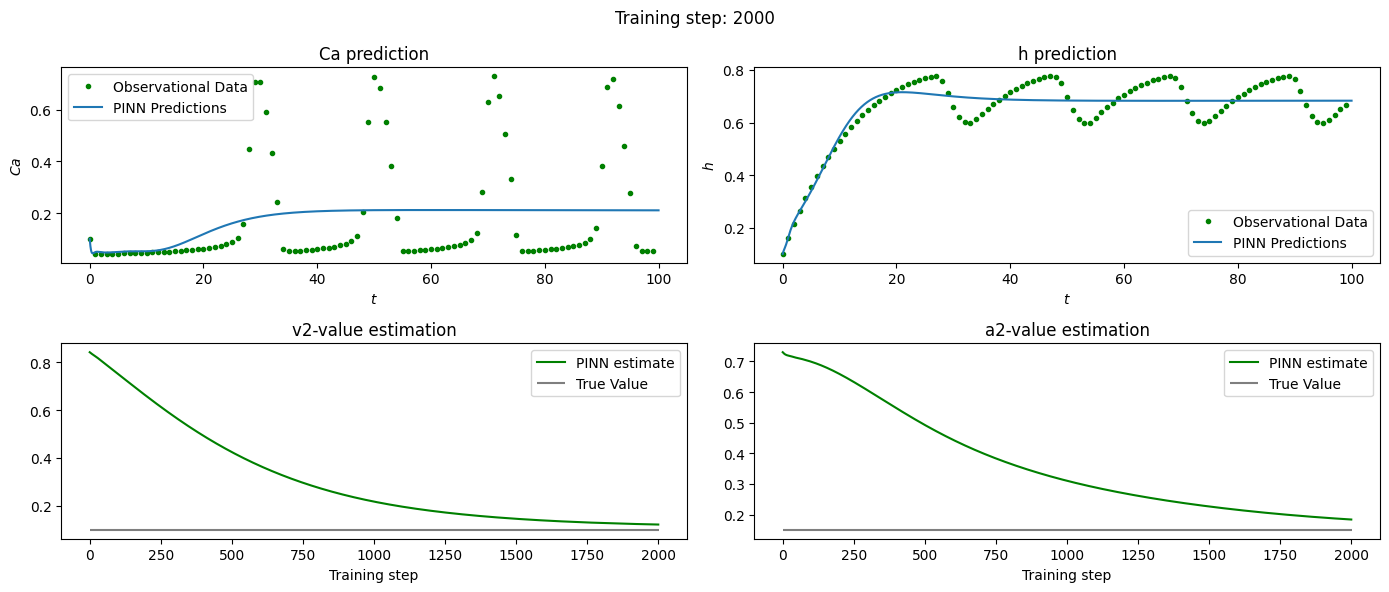

Training step: 3000
Loss = 0.0004356351855676621 | Physics_loss = 0.00013174189371056855| Initial_loss = 0.0 | Data_loss = 0.04343177750706673


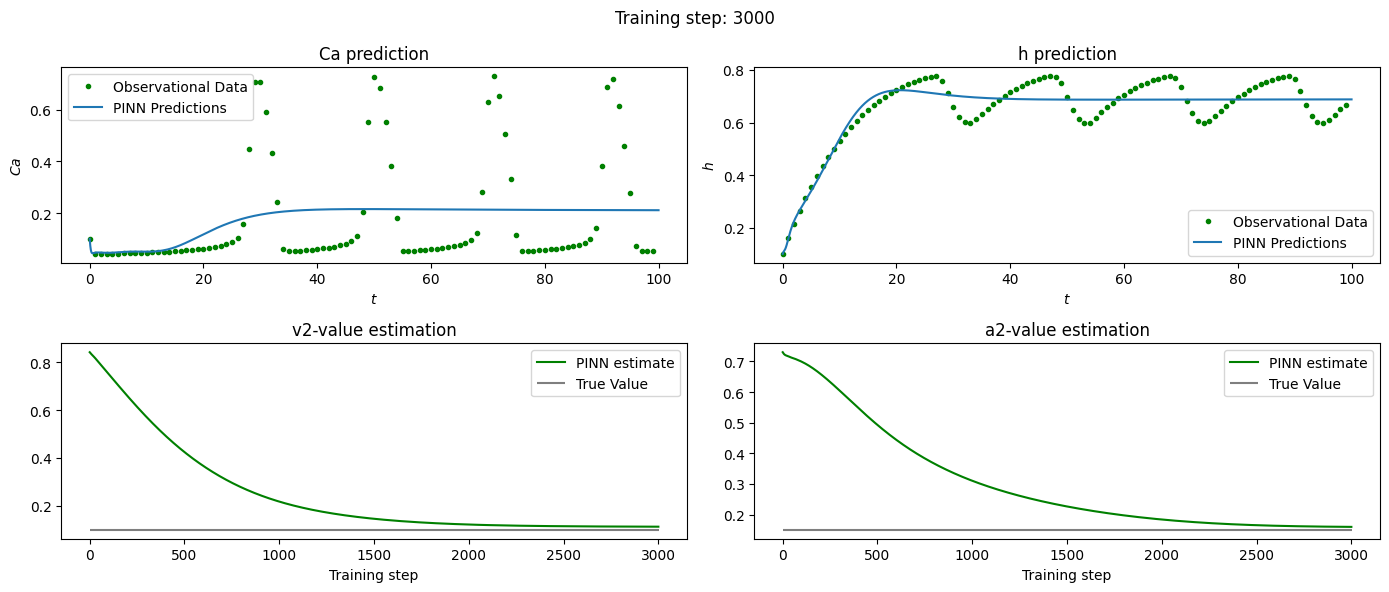

Training step: 4000
Loss = 0.0004348015645518899 | Physics_loss = 0.00015390718181151897| Initial_loss = 0.0 | Data_loss = 0.043326251208782196


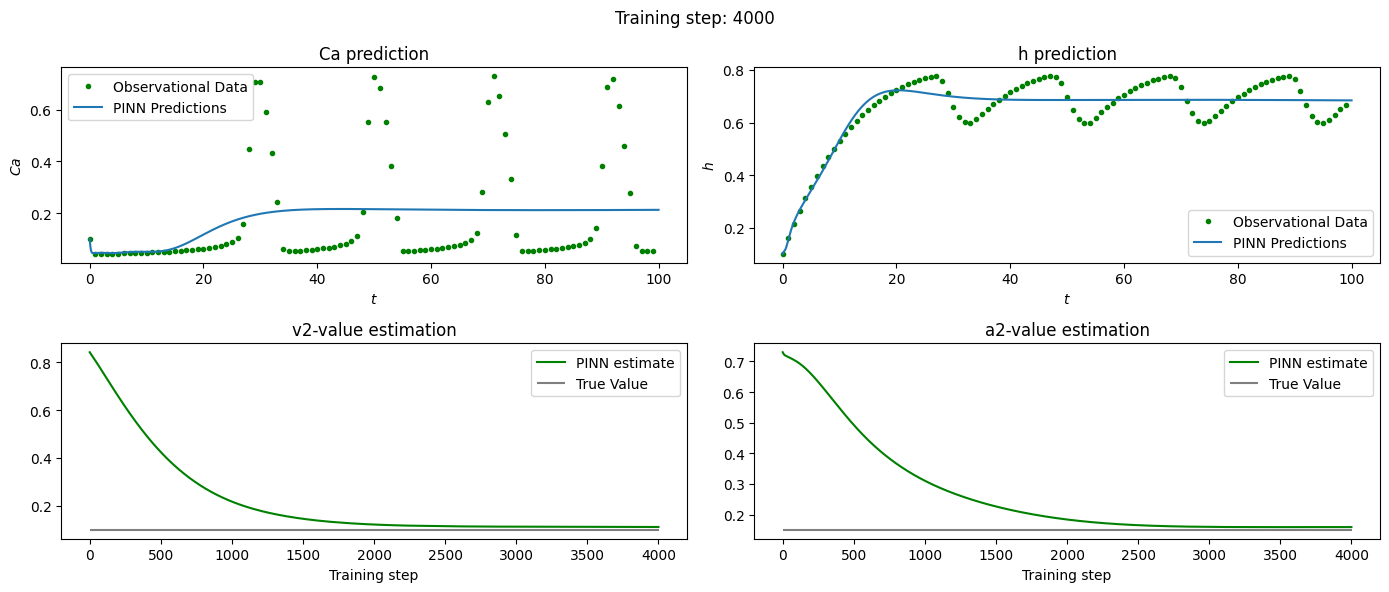

Training step: 5000
Loss = 0.00043362483847886324 | Physics_loss = 0.00013558143109548837| Initial_loss = 0.0 | Data_loss = 0.043226905167102814


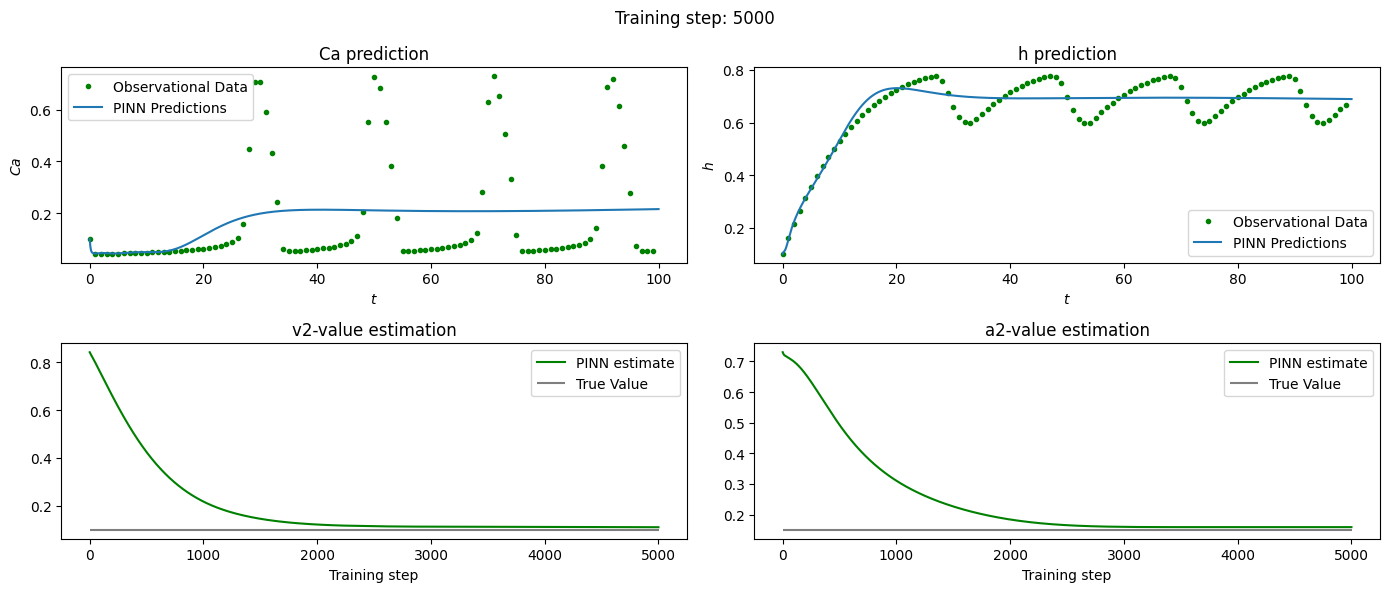

Training step: 6000
Loss = 0.0004316048580221832 | Physics_loss = 0.00010064170783152804| Initial_loss = 0.0 | Data_loss = 0.04305984452366829


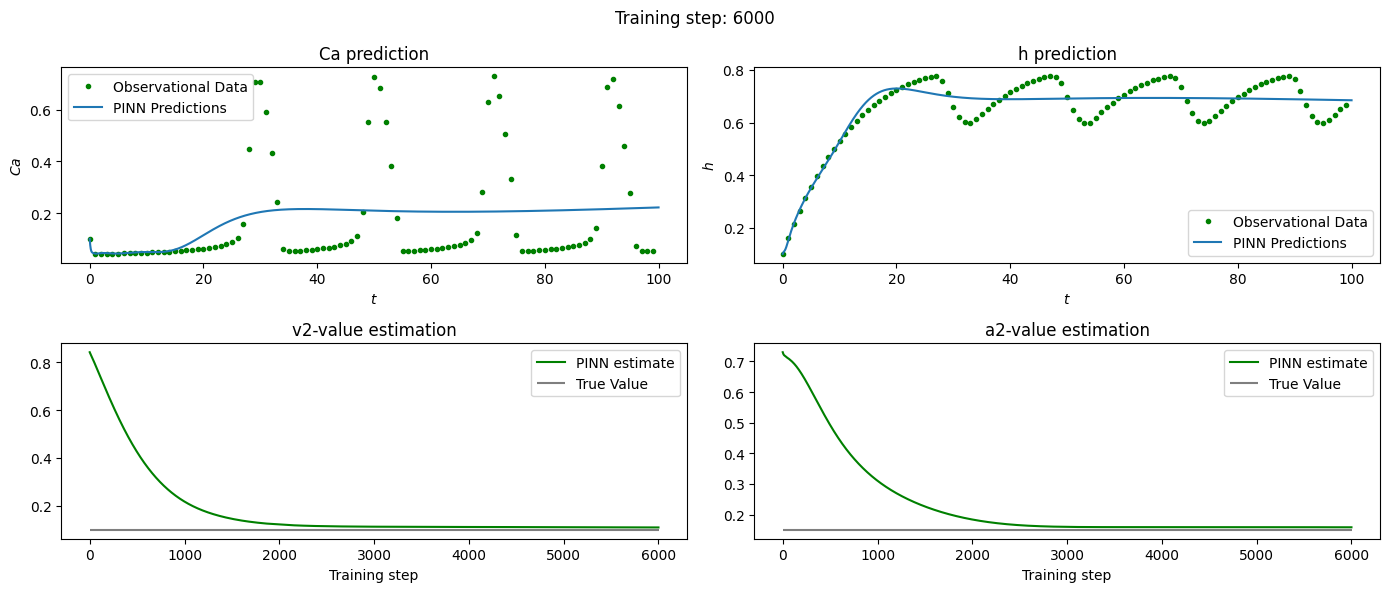

Training step: 7000
Loss = 0.0004305494367145002 | Physics_loss = 0.00013440822658594698| Initial_loss = 0.0 | Data_loss = 0.042920537292957306


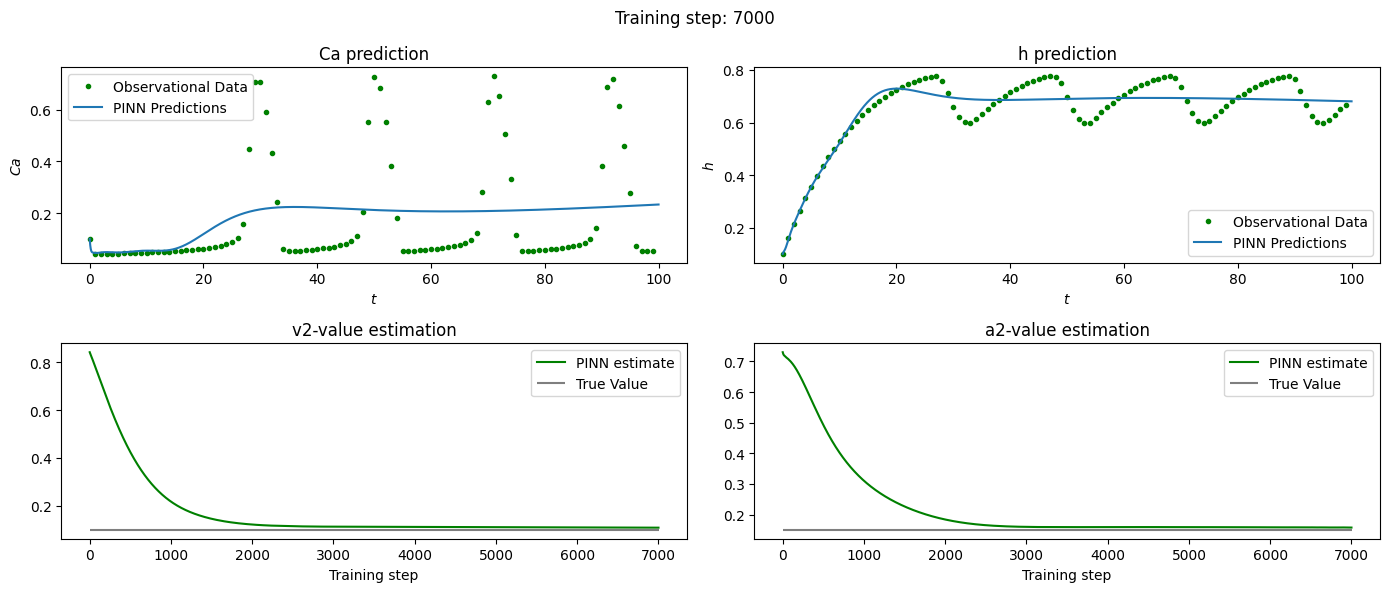

Training step: 8000
Loss = 0.00043480421300046146 | Physics_loss = 0.0005157519481144845| Initial_loss = 0.0 | Data_loss = 0.042964670807123184


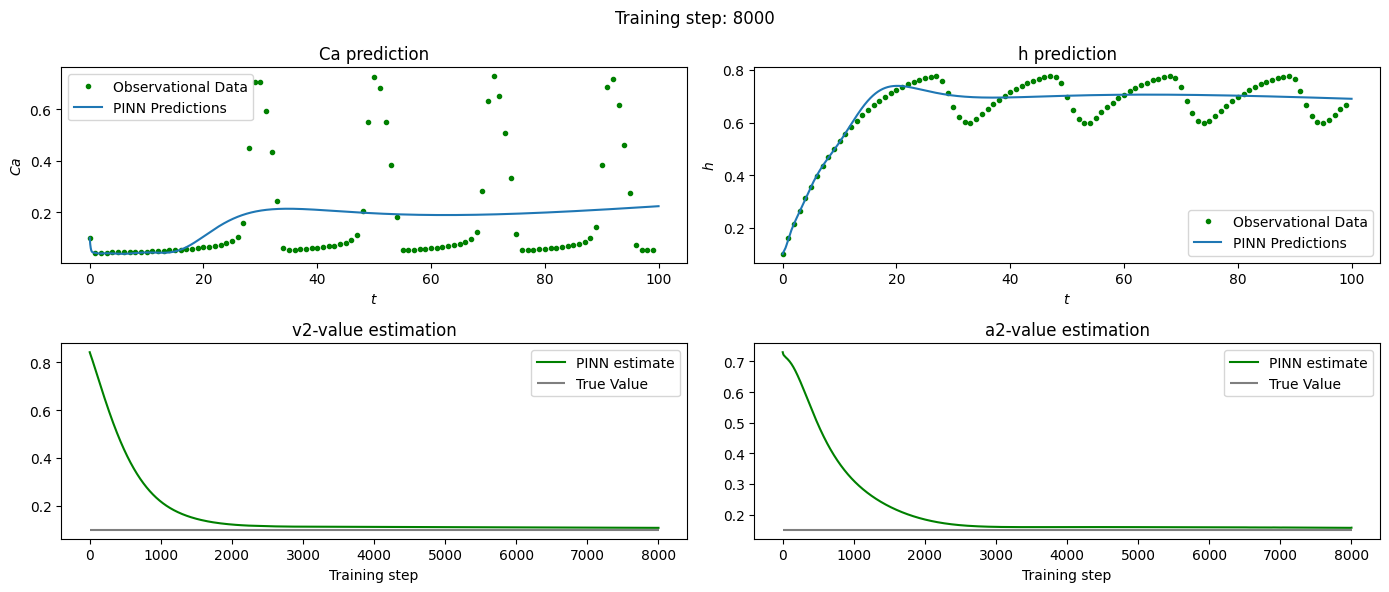

Training step: 9000
Loss = 0.0004321634769439697 | Physics_loss = 0.00040693354094401| Initial_loss = 0.0 | Data_loss = 0.042809415608644485


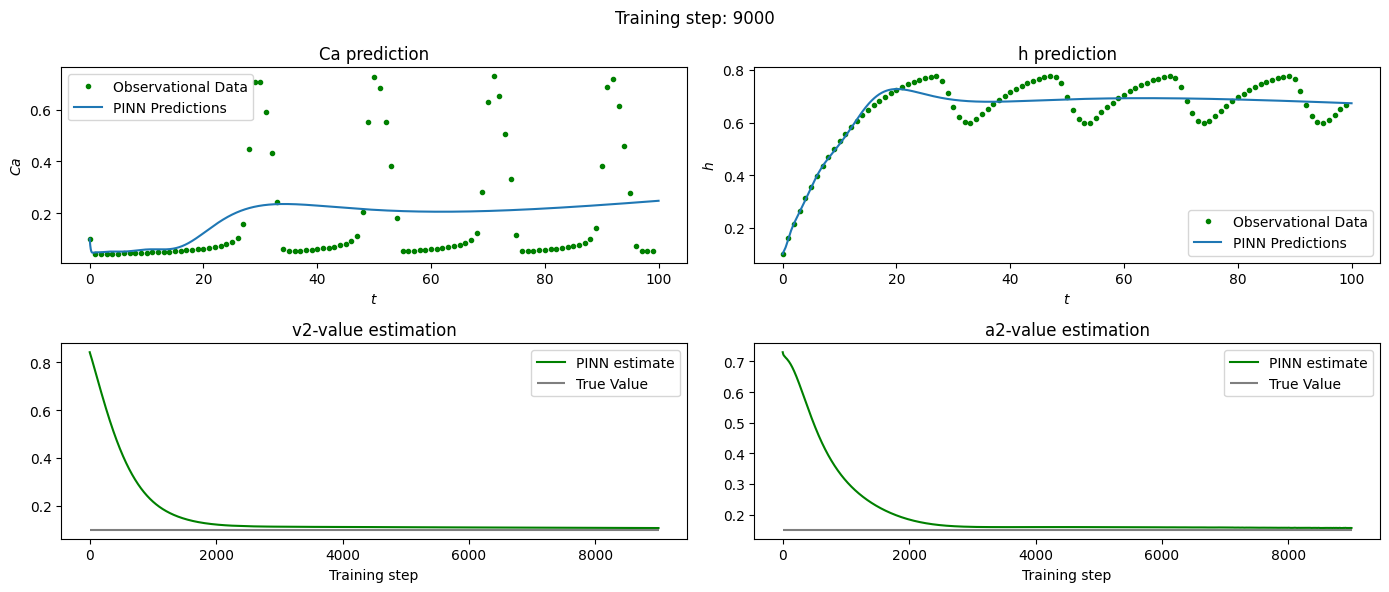

Training step: 10000
Loss = 0.0004305765905883163 | Physics_loss = 0.0003300386306364089| Initial_loss = 0.0 | Data_loss = 0.042727623134851456


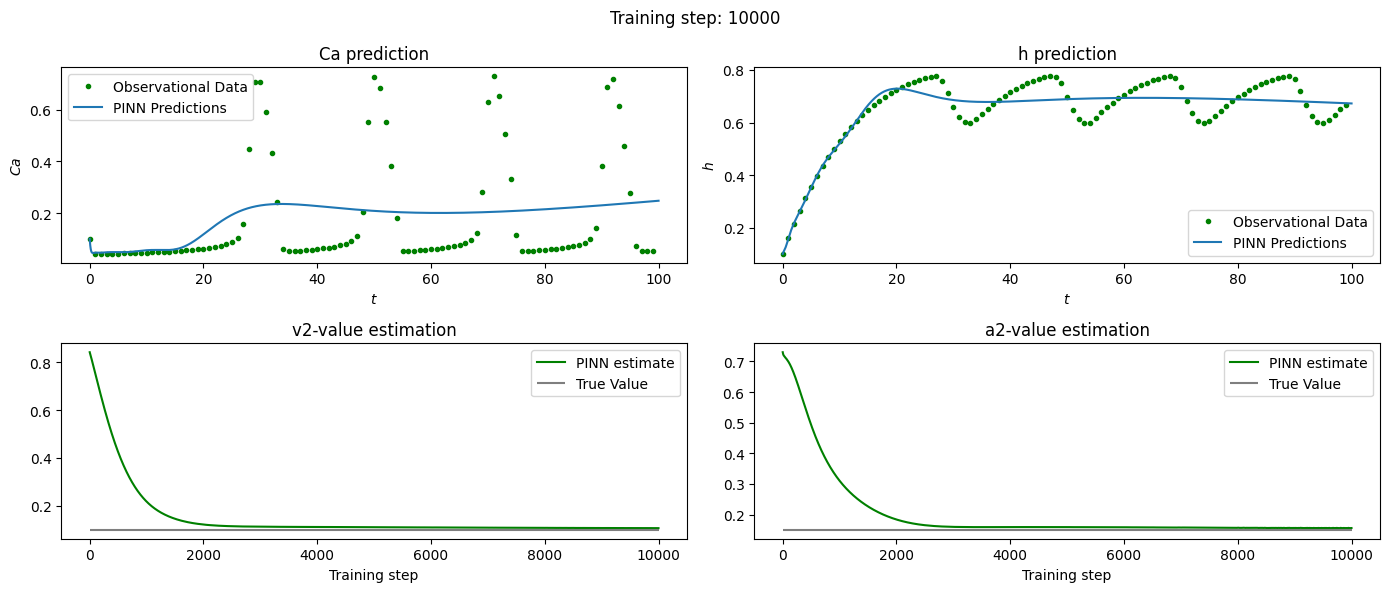

In [13]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, y0=torch.tensor([0.1, 0.1]).view(1,-1))

t_test = torch.arange(0, 100, 0.01).view(-1, 1).to(device)
time = torch.arange(0, 100, 1.0).view(-1, 1).to(device)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1).to(device)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.1, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [9]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features):
        super().__init__()
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        return out

Training step: 0
Loss = 0.02151709422469139 | Physics_loss = 1.3596527576446533| Initial_loss = 0.003960903268307447 | Data_loss = 0.39596641063690186


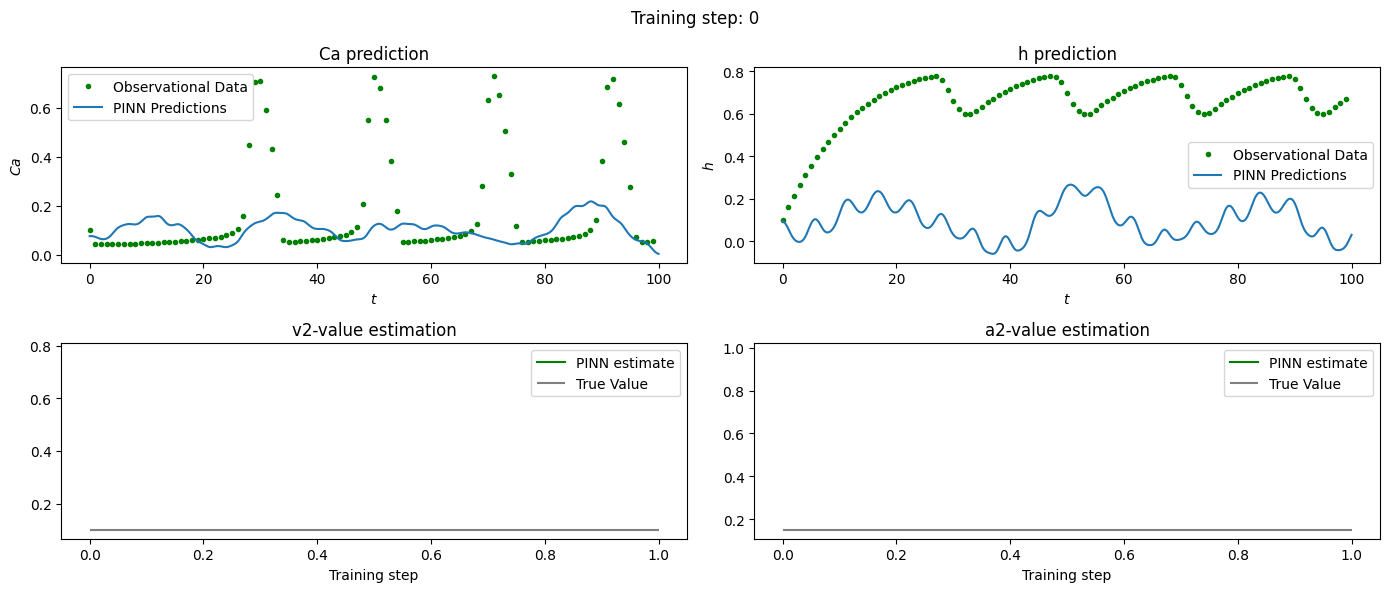

Training step: 1000
Loss = 0.00043825869215652347 | Physics_loss = 0.008346671238541603| Initial_loss = 2.206517820013687e-05 | Data_loss = 0.03327267989516258


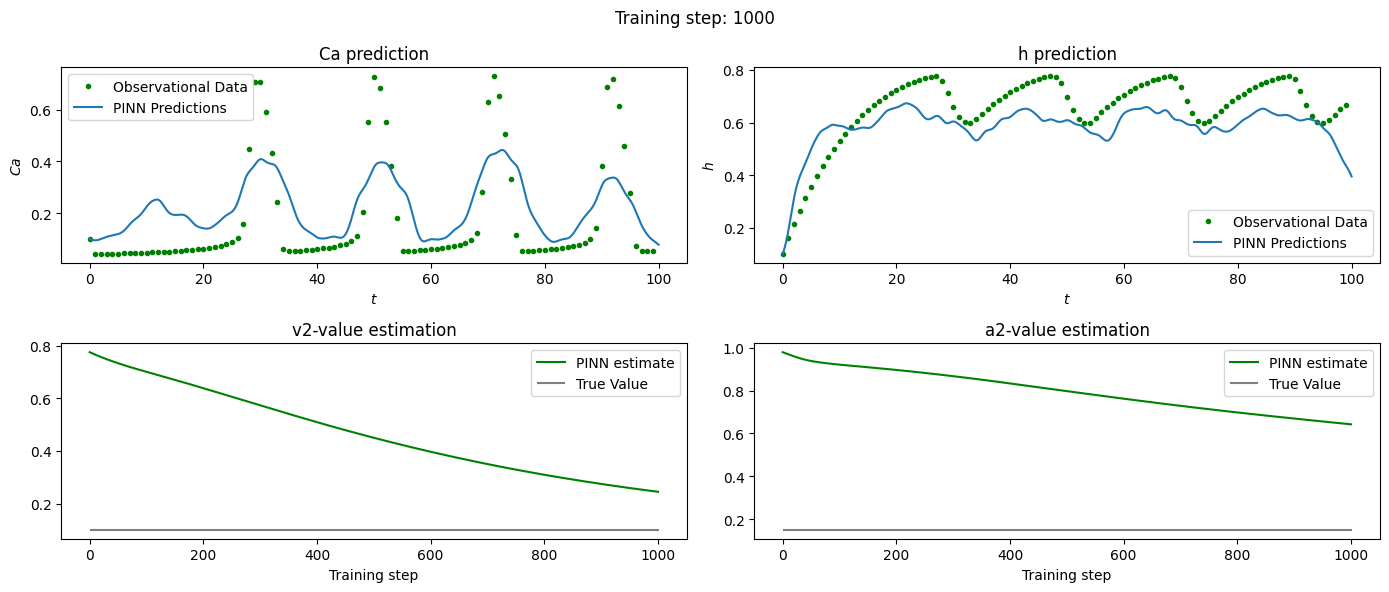

Training step: 2000
Loss = 0.00011121589341200888 | Physics_loss = 0.0035991095937788486| Initial_loss = 8.818465175863821e-07 | Data_loss = 0.007434295956045389


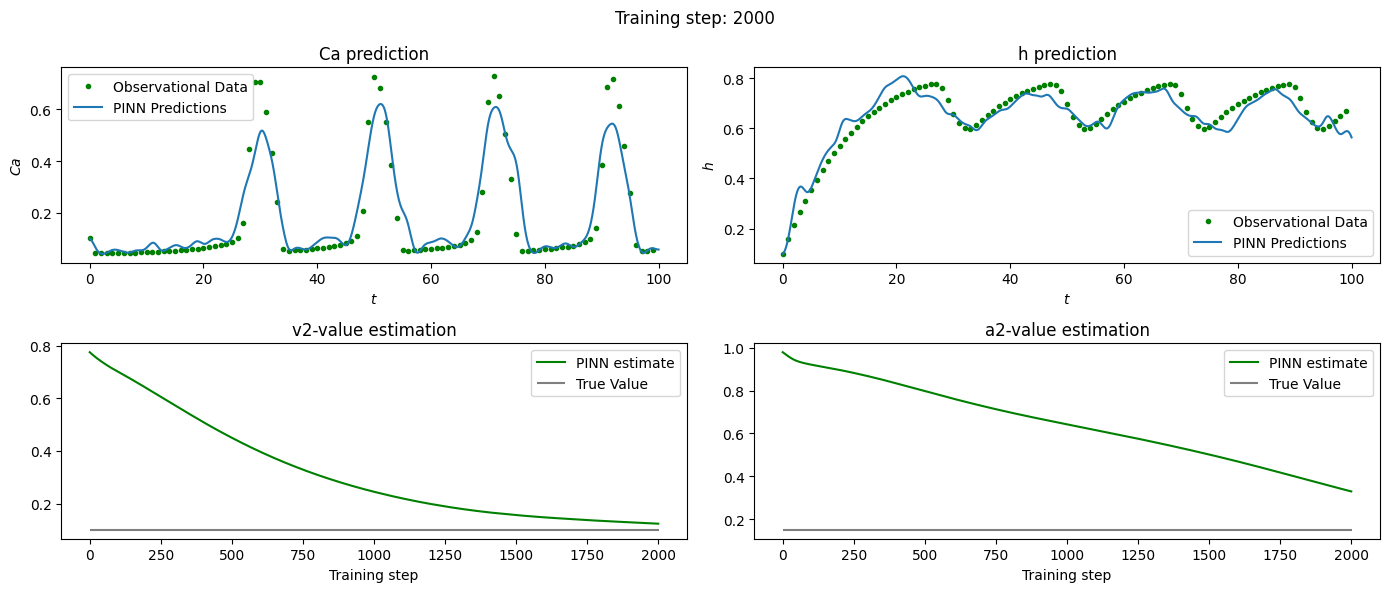

Training step: 3000
Loss = 4.8938913096208125e-05 | Physics_loss = 0.001700634602457285| Initial_loss = 8.599582379531512e-09 | Data_loss = 0.0031923968344926834


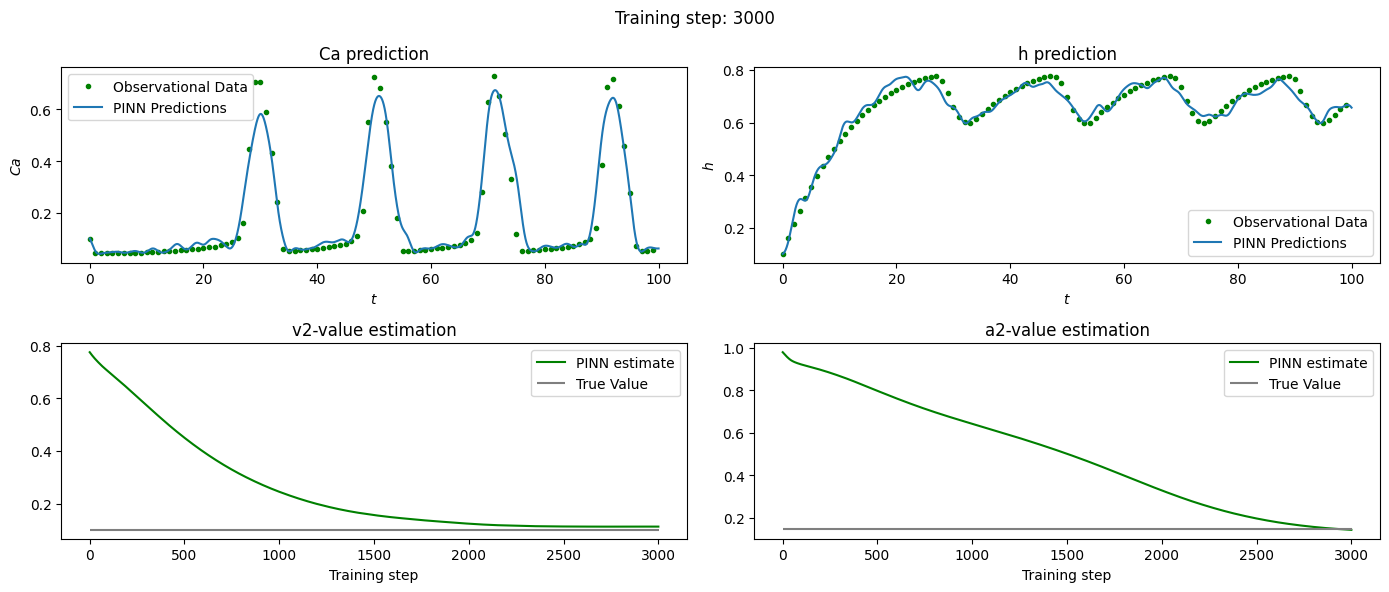

Training step: 4000
Loss = 2.5873005142784677e-05 | Physics_loss = 0.0011245430214330554| Initial_loss = 2.095978324234693e-08 | Data_loss = 0.0014606615295633674


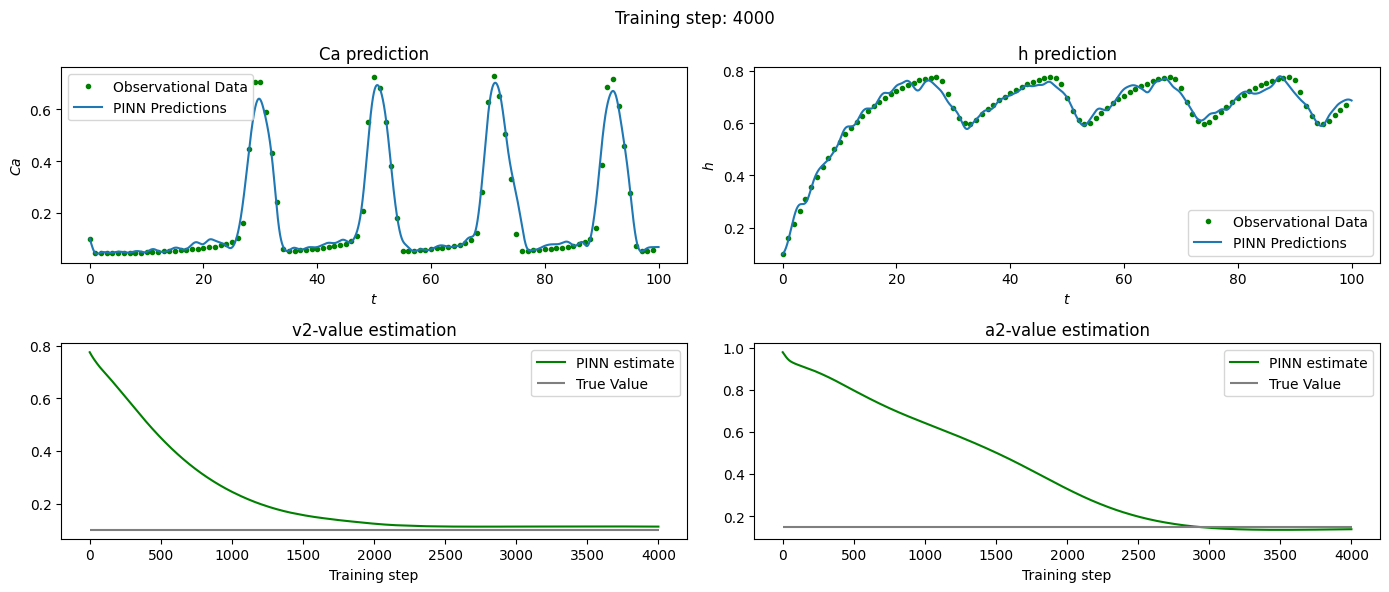

Training step: 5000
Loss = 1.511908158136066e-05 | Physics_loss = 0.0007973297033458948| Initial_loss = 1.7866434998126124e-09 | Data_loss = 0.000714399793650955


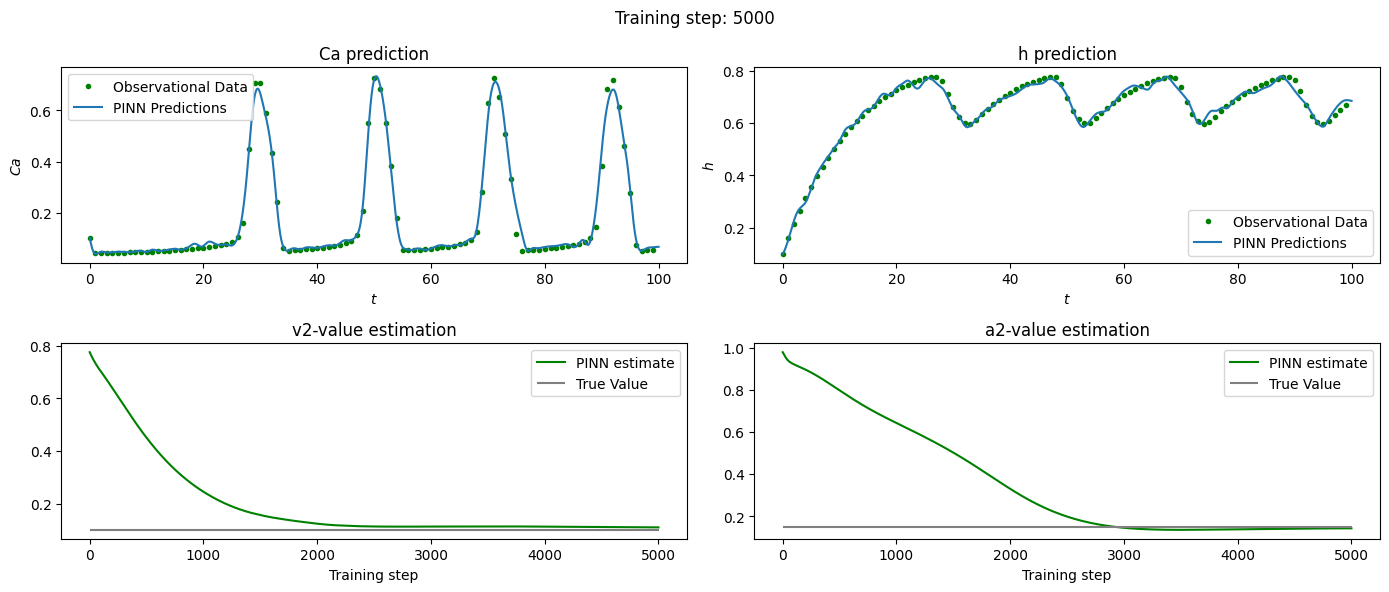

Training step: 6000
Loss = 1.1875998097821139e-05 | Physics_loss = 0.0006539371679536998| Initial_loss = 3.027684556400345e-07 | Data_loss = 0.0005033857887610793


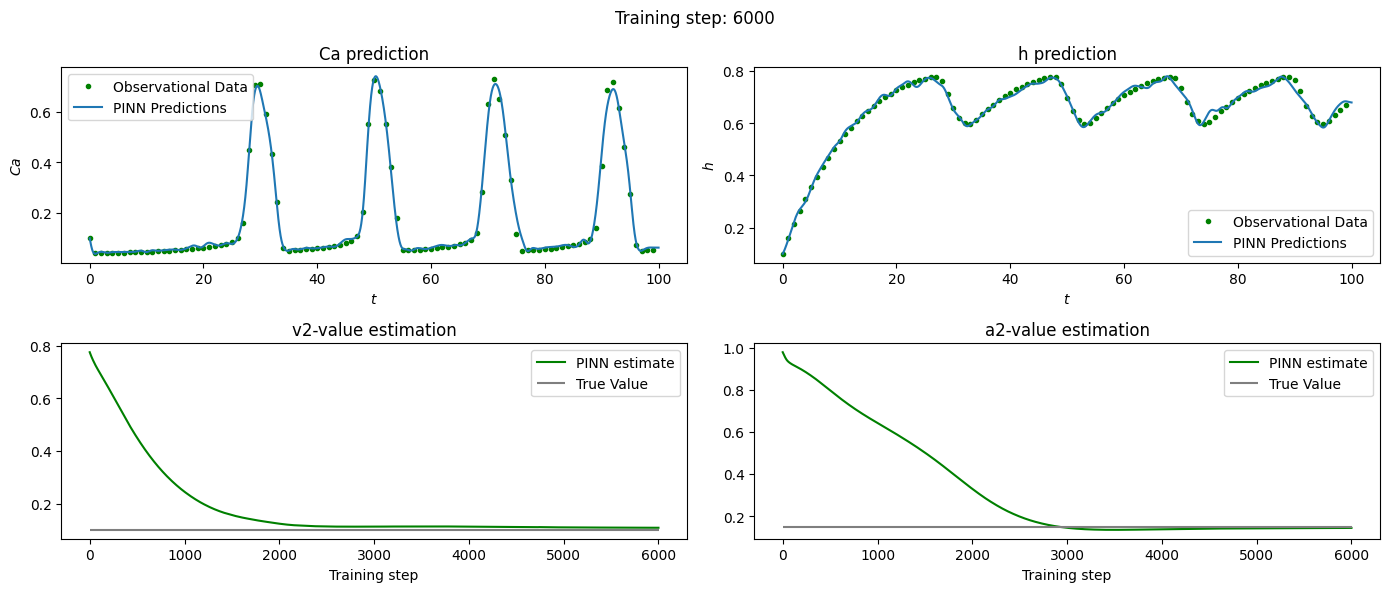

Training step: 7000
Loss = 9.363917342852801e-06 | Physics_loss = 0.0005547620821744204| Initial_loss = 1.9343175949870783e-07 | Data_loss = 0.0003622865187935531


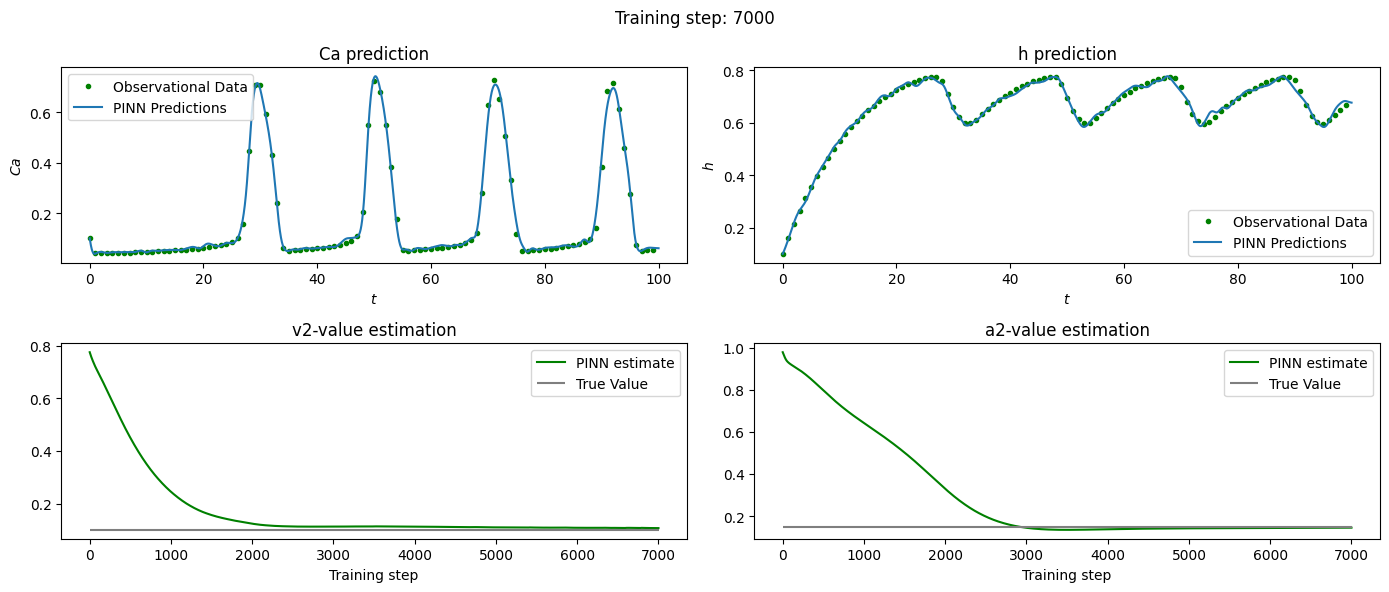

Training step: 8000
Loss = 7.492121312679956e-06 | Physics_loss = 0.0004608966992236674| Initial_loss = 2.9197506634659476e-08 | Data_loss = 0.0002853957121260464


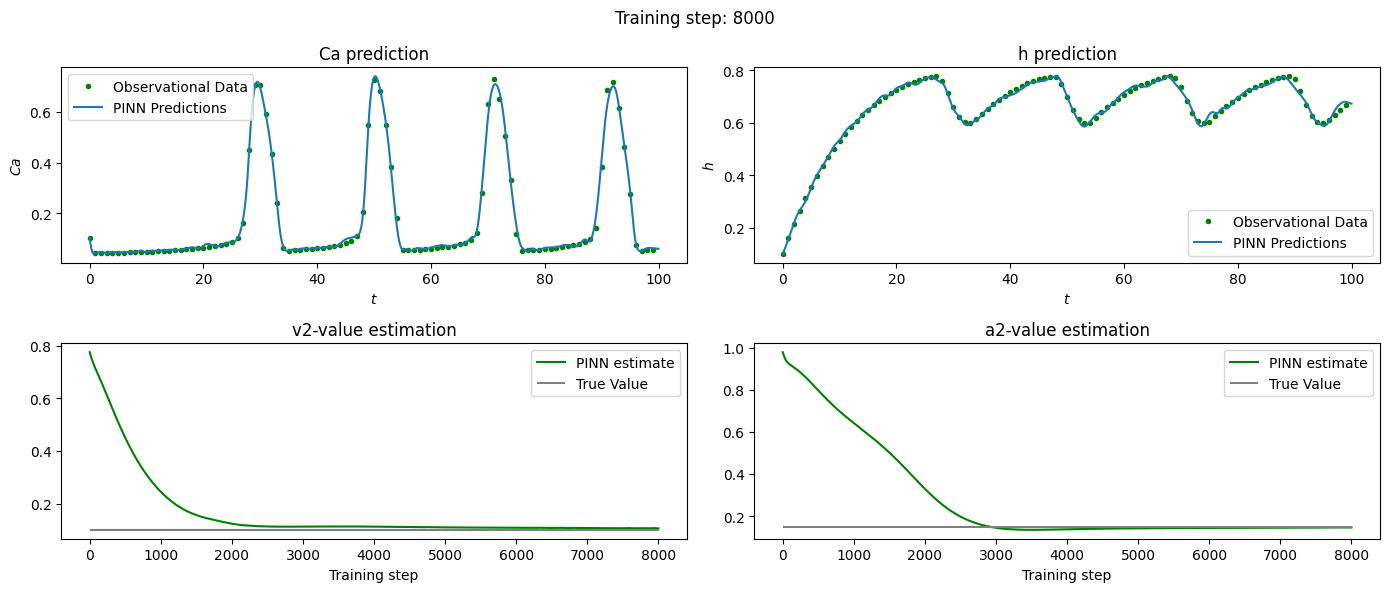

Training step: 9000
Loss = 6.2312838053912856e-06 | Physics_loss = 0.00038897187914699316| Initial_loss = 7.948862124074196e-10 | Data_loss = 0.00023407700064126402


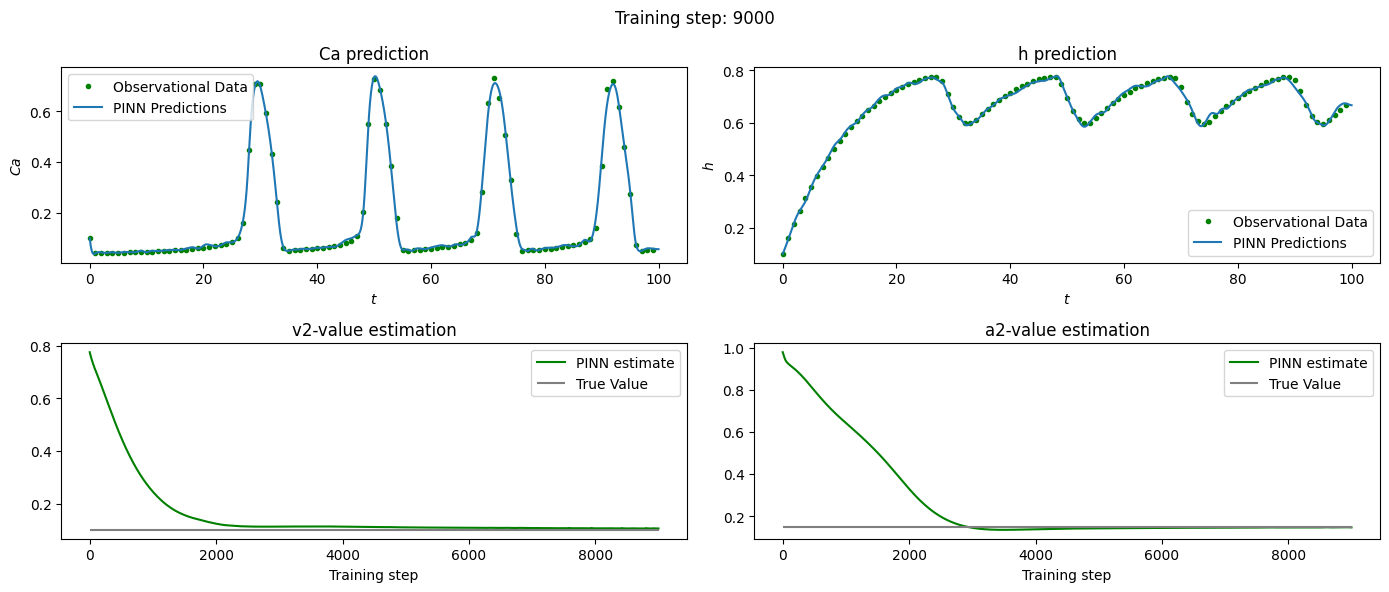

Training step: 10000
Loss = 5.154732662049355e-06 | Physics_loss = 0.0003291393513791263| Initial_loss = 1.9598949130283927e-09 | Data_loss = 0.00018613794236443937


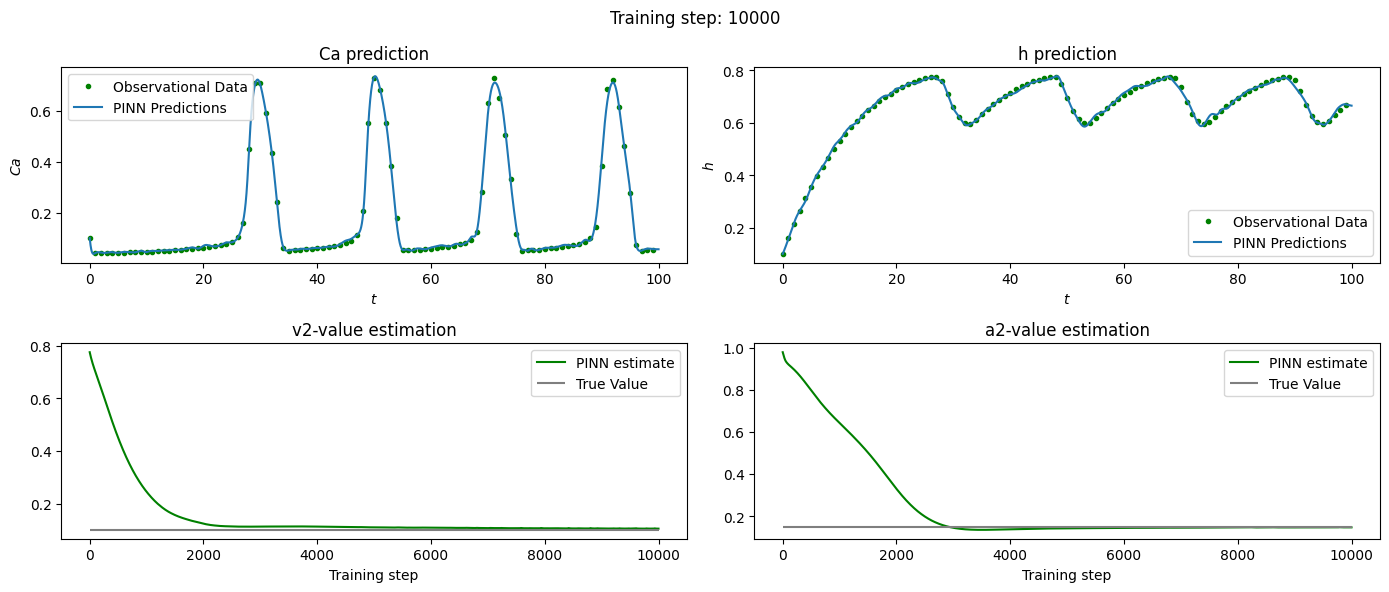

In [10]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3)

t_test = torch.arange(0, 100, 0.01).view(-1, 1).to(device)
time = torch.arange(0, 100, 1.0).view(-1, 1).to(device)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1).to(device)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.1, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [14]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

Training step: 0
Loss = 0.008535737171769142 | Physics_loss = 0.5694220662117004| Initial_loss = 0.0 | Data_loss = 0.28415173292160034


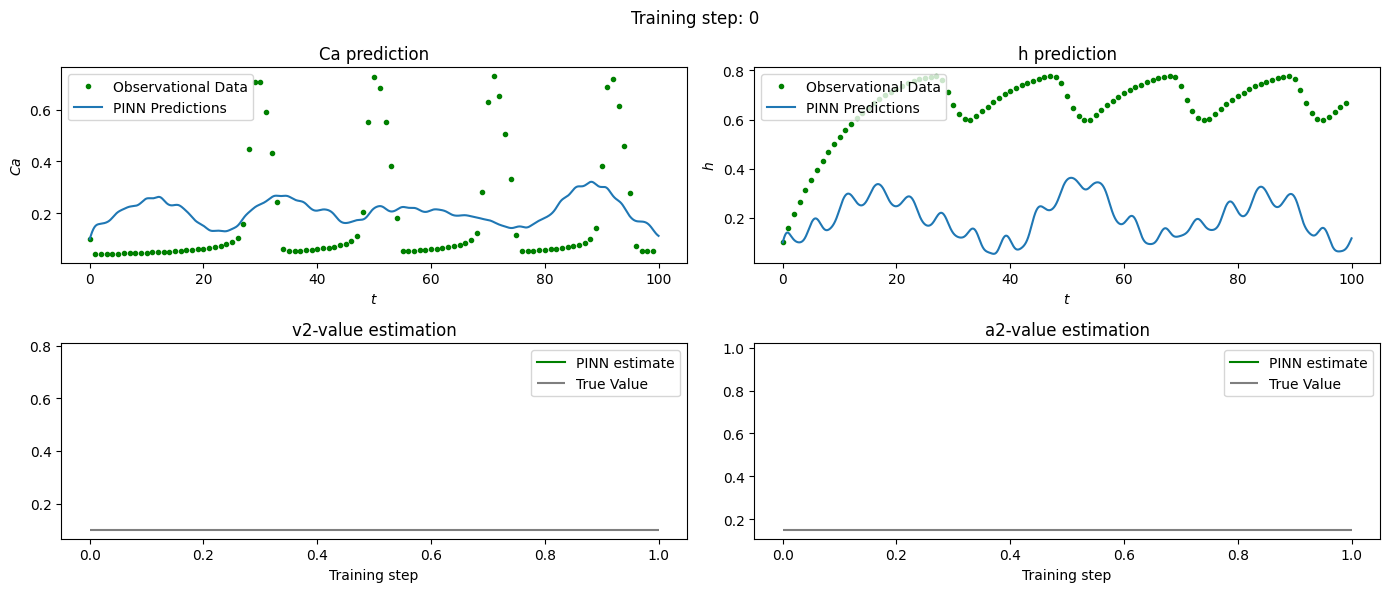

Training step: 1000
Loss = 7.231177733046934e-05 | Physics_loss = 0.003221903694793582| Initial_loss = 0.0 | Data_loss = 0.004009274300187826


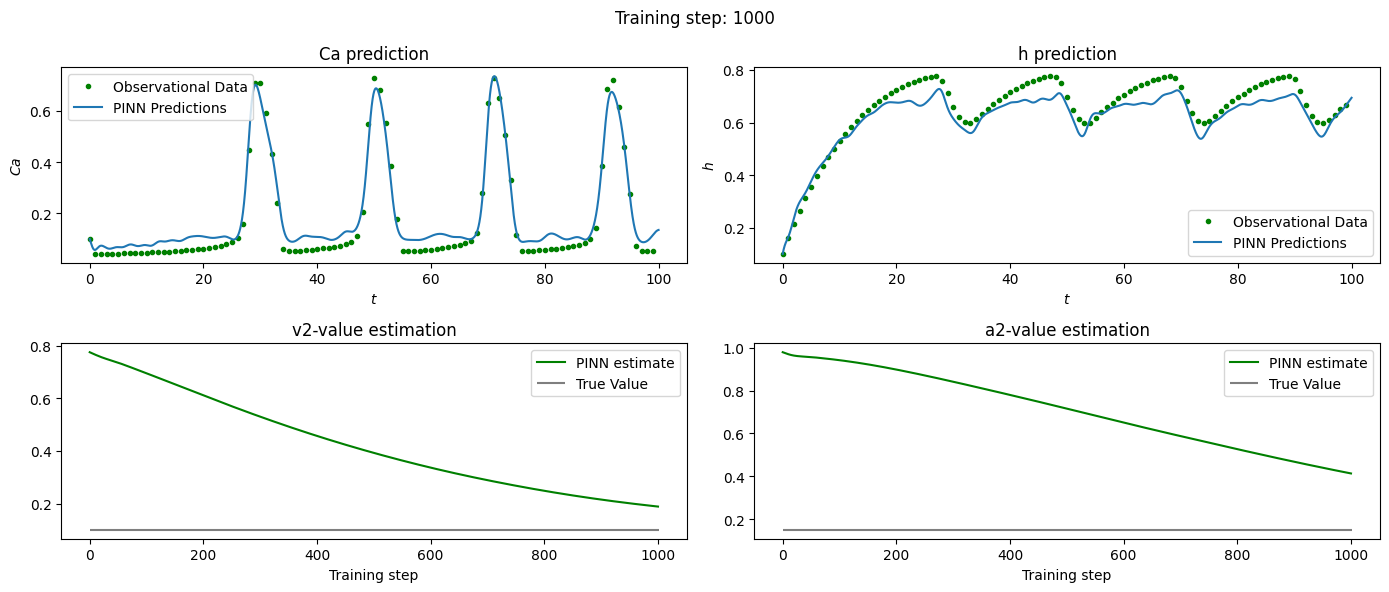

Training step: 2000
Loss = 6.793476131861098e-06 | Physics_loss = 0.0004991015885025263| Initial_loss = 0.0 | Data_loss = 0.00018024601740762591


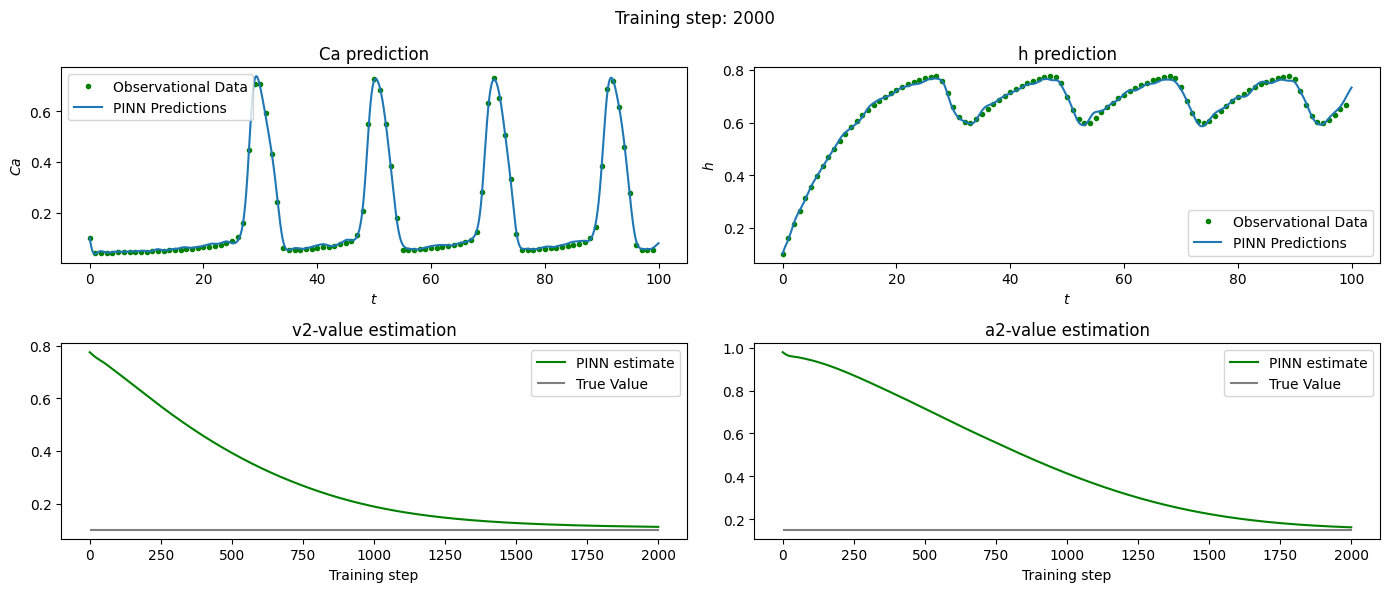

Training step: 3000
Loss = 3.9755445868649986e-06 | Physics_loss = 0.00033243882353417575| Initial_loss = 0.0 | Data_loss = 6.51156369713135e-05


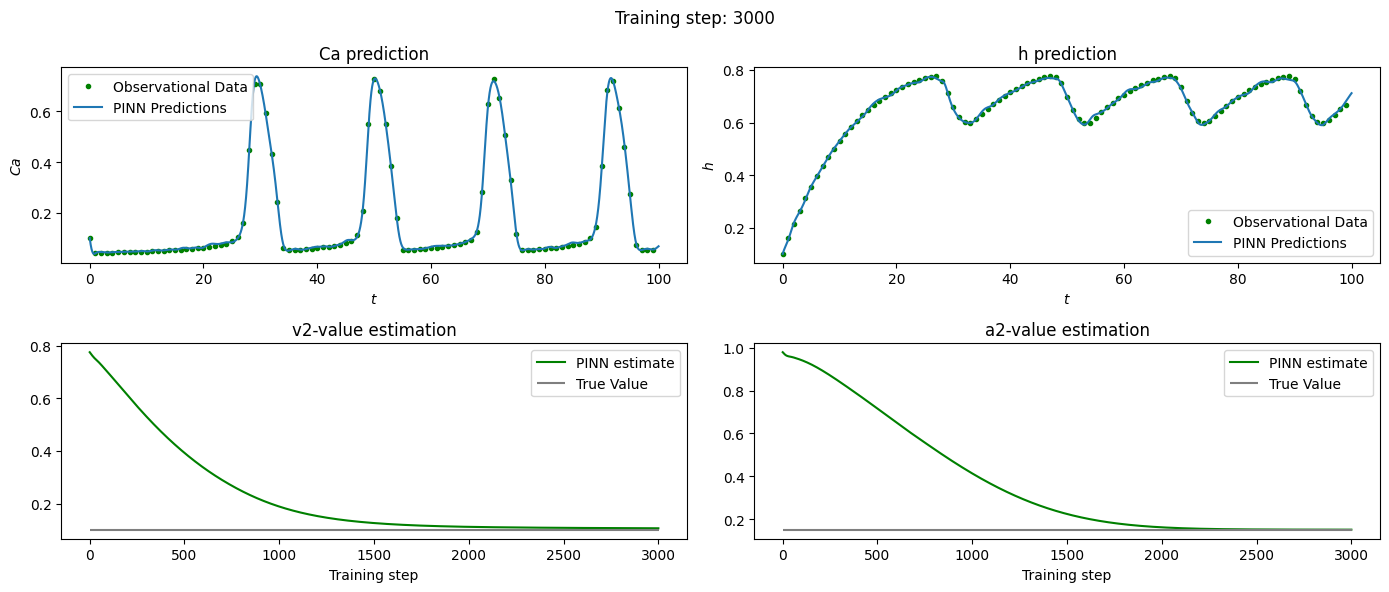

Training step: 4000
Loss = 3.972647391492501e-06 | Physics_loss = 0.00033893538056872785| Initial_loss = 0.0 | Data_loss = 5.832939859828912e-05


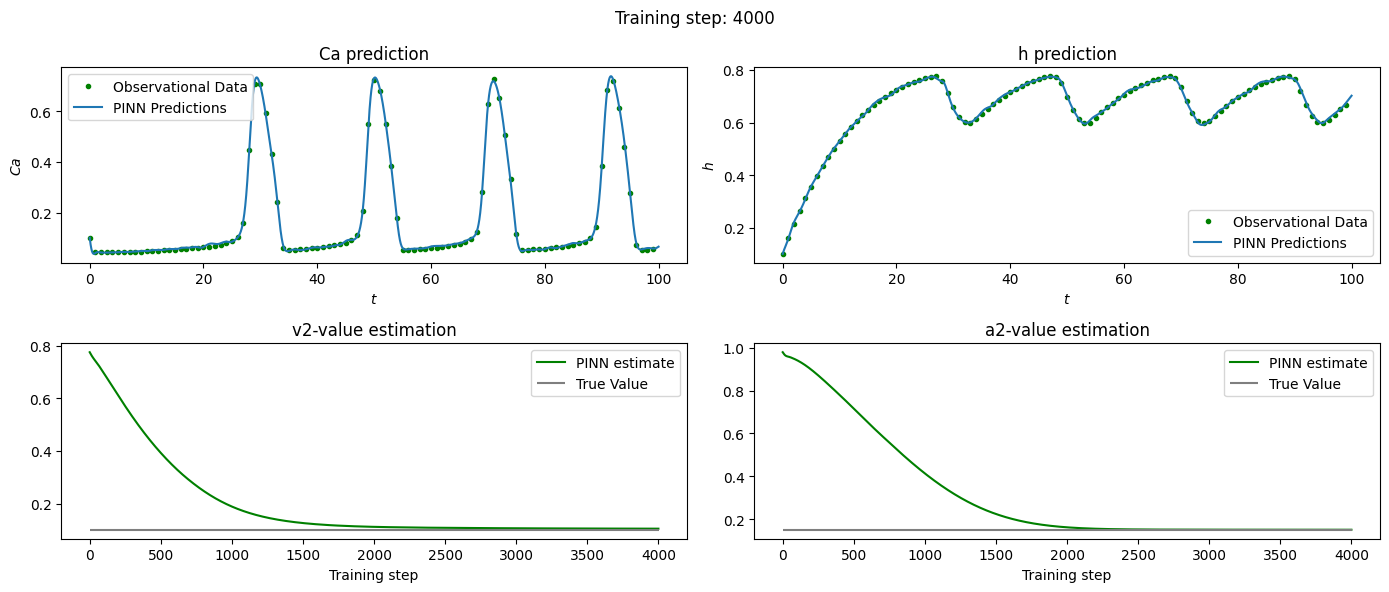

Training step: 5000
Loss = 2.3714403596386546e-06 | Physics_loss = 0.00021186166850384325| Initial_loss = 0.0 | Data_loss = 2.5282351998612285e-05


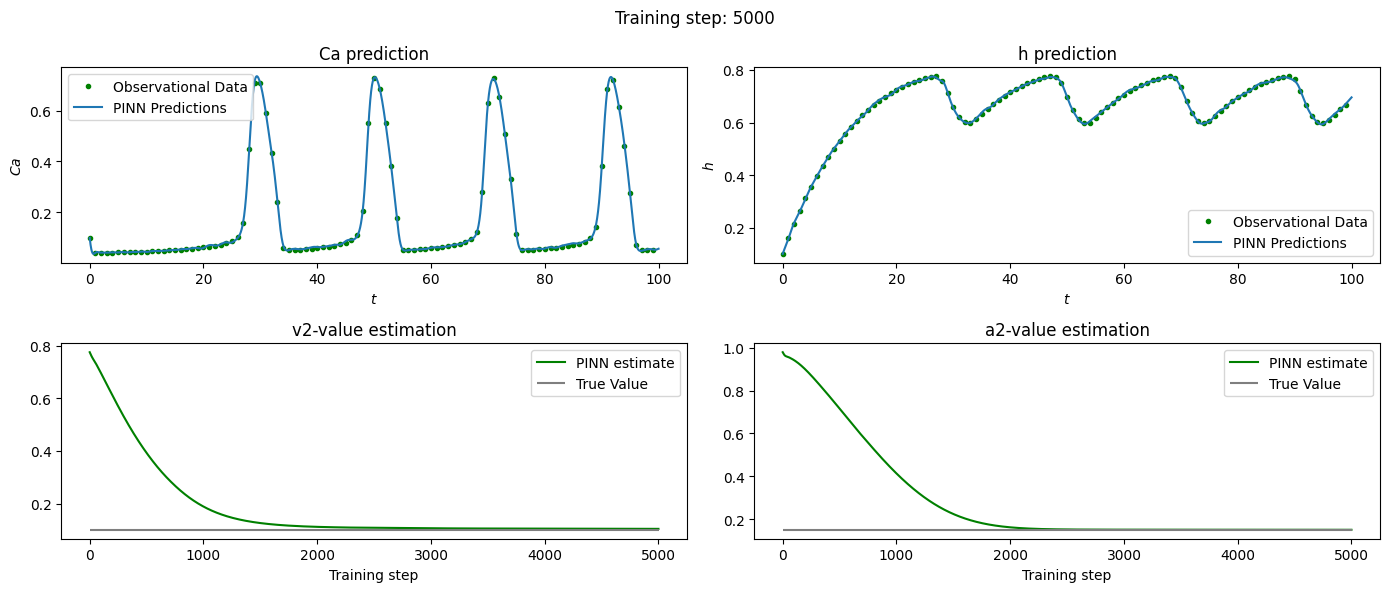

Training step: 6000
Loss = 3.0975820664025377e-06 | Physics_loss = 0.0002871727047022432| Initial_loss = 0.0 | Data_loss = 2.2585496481042355e-05


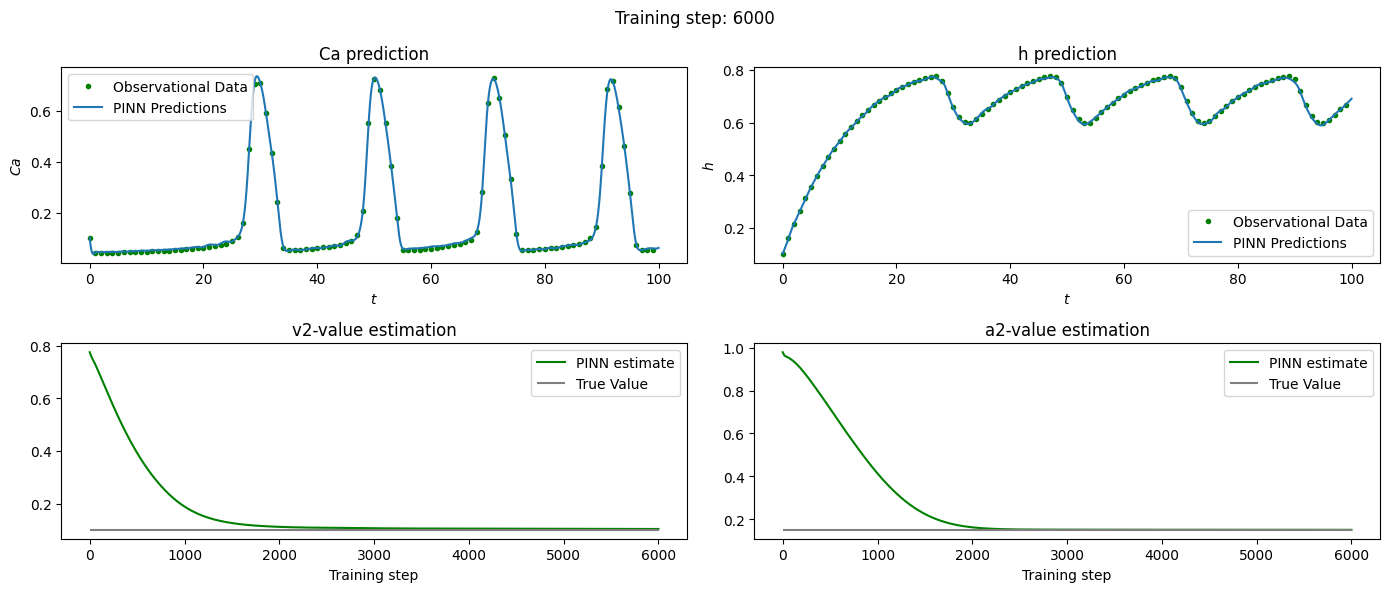

Training step: 7000
Loss = 2.5868901047942927e-06 | Physics_loss = 0.00023325408983509988| Initial_loss = 0.0 | Data_loss = 2.5434925191802904e-05


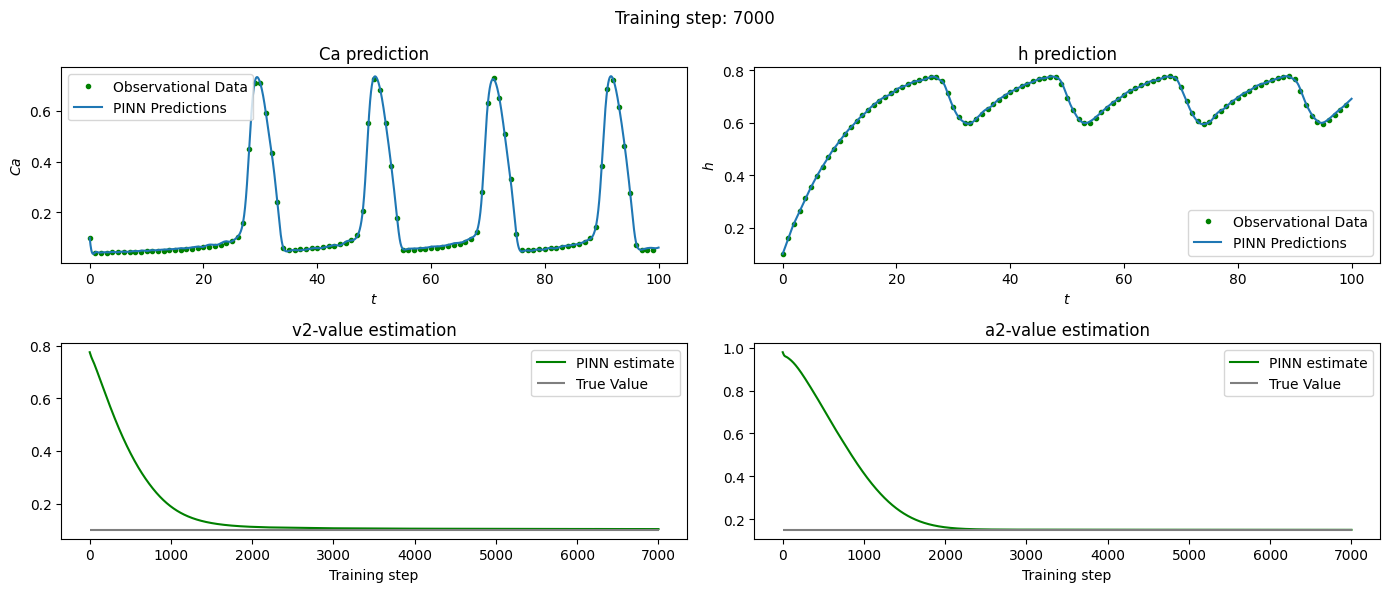

Training step: 8000
Loss = 1.8601790543470997e-06 | Physics_loss = 0.00017063065024558455| Initial_loss = 0.0 | Data_loss = 1.5387264284072444e-05


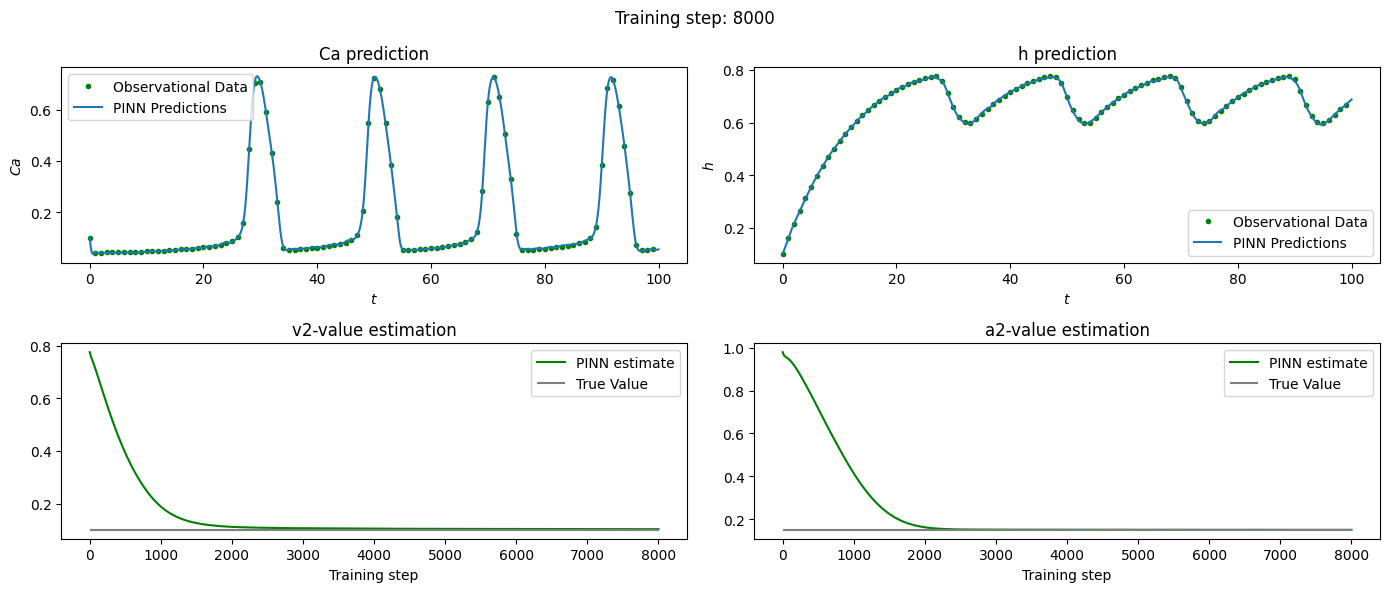

Training step: 9000
Loss = 1.1251979685766855e-06 | Physics_loss = 0.0001034687229548581| Initial_loss = 0.0 | Data_loss = 9.051081178768072e-06


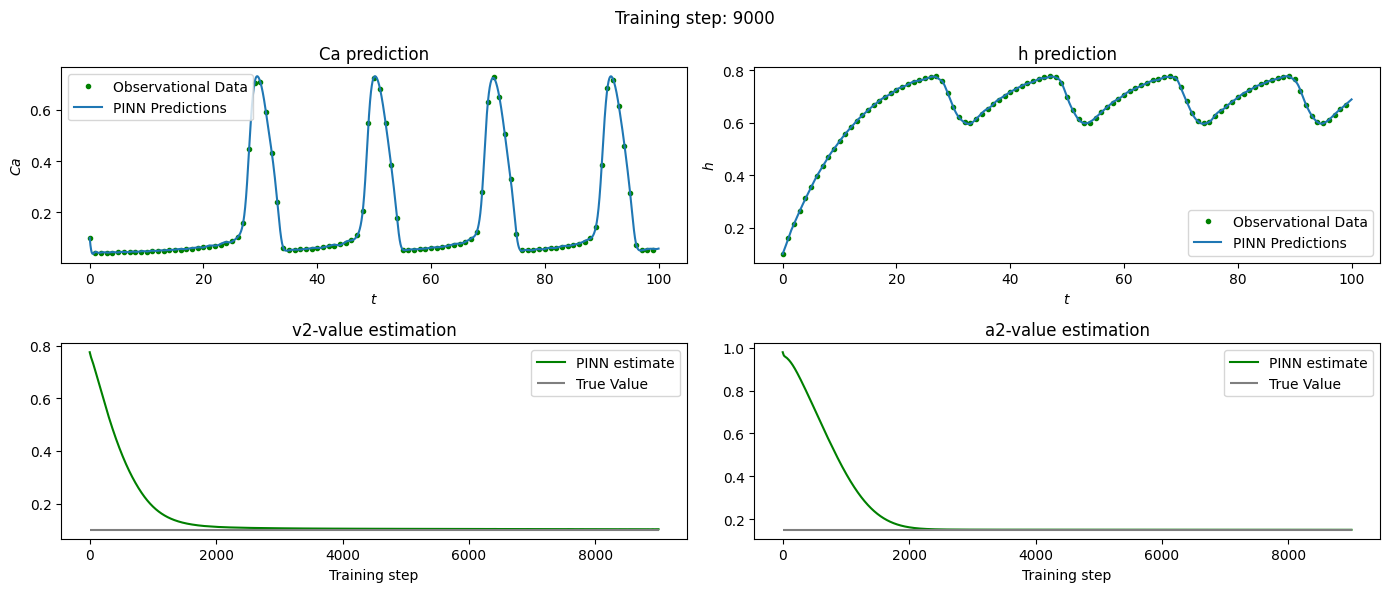

Training step: 10000
Loss = 1.4138440747046843e-06 | Physics_loss = 0.00012652868463192135| Initial_loss = 0.0 | Data_loss = 1.4855721019557677e-05


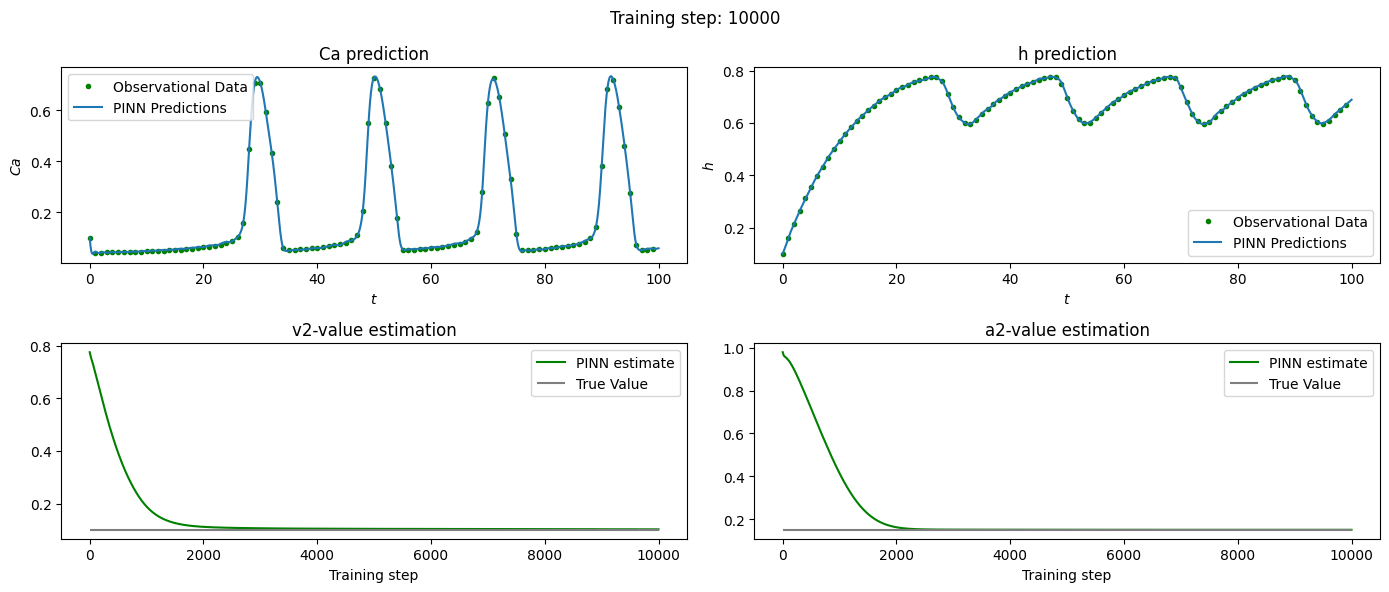

In [15]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

t_test = torch.arange(0, 100, 0.01).view(-1, 1).to(device)
time = torch.arange(0, 100, 1.0).view(-1, 1).to(device)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1).to(device)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1).to(device)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.1
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.1, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()
